In [ ]:
# @title Setup and Load Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- Configuration ---
# Assuming your files are uploaded directly to the Colab session storage
# If they are in Google Drive, you'll need to mount it first:
# from google.colab import drive
# drive.mount('/content/drive')
# And adjust the file_paths accordingly, e.g., '/content/drive/MyDrive/your_folder/'

# Adjust file names if they differ slightly
price_files = {
    0: 'prices_round_3_day_0.csv',
    1: 'prices_round_3_day_1.csv',
    2: 'prices_round_3_day_2.csv',
}

trade_files = {
    0: 'trades_round_3_day_0.csv',
    1: 'trades_round_3_day_1.csv',
    2: 'trades_round_3_day_2.csv',
}

# --- Load Data ---
price_dfs = []
trade_dfs = []

print("--- Loading Price Data ---")
for day, filename in price_files.items():
    if os.path.exists(filename):
        print(f"Loading {filename}...")
        try:
            df = pd.read_csv(filename, delimiter=';')
            df['day'] = day # Ensure day column is correct based on file
            price_dfs.append(df)
            print(f"Loaded {filename} successfully. Shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    else:
        print(f"Warning: File not found - {filename}")

print("\n--- Loading Trade Data ---")
for day, filename in trade_files.items():
    if os.path.exists(filename):
        print(f"Loading {filename}...")
        try:
            df = pd.read_csv(filename, delimiter=';')
            # Trades file might not have a day column, add it based on filename
            df['day'] = day
            trade_dfs.append(df)
            print(f"Loaded {filename} successfully. Shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    else:
        print(f"Warning: File not found - {filename}")

# --- Combine Data ---
if price_dfs:
    prices_df = pd.concat(price_dfs, ignore_index=True)
    print(f"\nCombined Prices DataFrame Shape: {prices_df.shape}")
else:
    print("\nNo price data loaded.")
    prices_df = pd.DataFrame() # Create empty df to avoid errors later

if trade_dfs:
    trades_df = pd.concat(trade_dfs, ignore_index=True)
    print(f"Combined Trades DataFrame Shape: {trades_df.shape}")
else:
    print("\nNo trade data loaded.")
    trades_df = pd.DataFrame() # Create empty df to avoid errors later

# Set consistent plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

print("\nSetup and Data Loading Complete.")

# @title Data Inspection
if not prices_df.empty:
    print("\n--- Prices DataFrame Info ---")
    prices_df.info()
    print("\n--- Prices DataFrame Head ---")
    print(prices_df.head())
    print("\n--- Prices DataFrame Numerical Summary ---")
    # Select only numeric columns for describe, handle potential non-numeric ones
    print(prices_df.select_dtypes(include=np.number).describe())
    print("\n--- Unique Products (Prices) ---")
    print(prices_df['product'].unique())
    print(f"Number of unique products: {prices_df['product'].nunique()}")
    print("\n--- Missing Values (Prices) ---")
    print(prices_df.isnull().sum()) # Check for missing values, esp. in key columns

if not trades_df.empty:
    print("\n--- Trades DataFrame Info ---")
    trades_df.info()
    print("\n--- Trades DataFrame Head ---")
    print(trades_df.head())
    print("\n--- Trades DataFrame Numerical Summary ---")
    print(trades_df.select_dtypes(include=np.number).describe())
    print("\n--- Unique Symbols (Trades) ---")
    # Use 'symbol' column from trades data
    print(trades_df['symbol'].unique())
    print(f"Number of unique symbols: {trades_df['symbol'].nunique()}")
    print("\n--- Missing Values (Trades) ---")
    print(trades_df.isnull().sum())
    # Check buyer/seller columns - often empty if trades are internal/market maker
    print("\n--- Buyer/Seller Info (Trades) ---")
    print("Unique Buyers:", trades_df['buyer'].unique())
    print("Unique Sellers:", trades_df['seller'].unique())
    print("Buyer Null Count:", trades_df['buyer'].isnull().sum())
    print("Seller Null Count:", trades_df['seller'].isnull().sum())


# @title Price Trend Analysis (Mid Price)

if not prices_df.empty:
    print("\n--- Plotting Mid Price Trends Per Day ---")
    products = prices_df['product'].unique()
    days = sorted(prices_df['day'].unique())

    # Determine how many products to plot together for readability
    # Separate Volcanic items from others maybe?
    volcanic_items = [p for p in products if 'VOLCANIC' in p]
    other_items = [p for p in products if 'VOLCANIC' not in p]

    for day in days:
        plt.figure(figsize=(18, 8))
        day_prices = prices_df[prices_df['day'] == day].copy() # Work on a copy

        # Plot Volcanic items
        for product in volcanic_items:
            product_data = day_prices[day_prices['product'] == product]
            if not product_data.empty:
                plt.plot(product_data['timestamp'], product_data['mid_price'], label=f'{product}')

        plt.title(f'Volcanic Rock & Voucher Mid Prices - Day {day}')
        plt.xlabel('Timestamp')
        plt.ylabel('Mid Price')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Move legend outside plot
        plt.tight_layout()
        plt.show()

        # Plot Other items
        plt.figure(figsize=(18, 8))
        for product in other_items:
             product_data = day_prices[day_prices['product'] == product]
             if not product_data.empty:
                # Check for very different scales - might need separate plots or y-axes
                # Basic check: if price range is huge, consider separate plots
                if product_data['mid_price'].max() > 10 * product_data['mid_price'].min() and product_data['mid_price'].min() > 0:
                     print(f"Note: {product} on Day {day} has a large price range, consider plotting separately if needed.")
                plt.plot(product_data['timestamp'], product_data['mid_price'], label=f'{product}')

        plt.title(f'Other Commodity Mid Prices - Day {day}')
        plt.xlabel('Timestamp')
        plt.ylabel('Mid Price')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()

else:
    print("Price data is empty. Skipping price trend analysis.")


# @title Trade Analysis

if not trades_df.empty:
    print("\n--- Trade Volume Analysis ---")
    # Total quantity traded per product per day
    trade_volume = trades_df.groupby(['day', 'symbol'])['quantity'].sum().reset_index()
    # Average trade price per product per day
    avg_trade_price = trades_df.groupby(['day', 'symbol'])['price'].mean().reset_index()
    # Number of trades per product per day
    trade_count = trades_df.groupby(['day', 'symbol']).size().reset_index(name='trade_count')

    # Combine trade stats
    trade_summary = pd.merge(trade_volume, avg_trade_price, on=['day', 'symbol'])
    trade_summary = pd.merge(trade_summary, trade_count, on=['day', 'symbol'])
    print(trade_summary)

    # Visualize Trade Volume per Day
    for day in sorted(trades_df['day'].unique()):
        plt.figure(figsize=(15, 6))
        day_summary = trade_summary[trade_summary['day'] == day]
        sns.barplot(data=day_summary, x='symbol', y='quantity')
        plt.title(f'Total Trade Volume per Product - Day {day}')
        plt.xlabel('Product Symbol')
        plt.ylabel('Total Quantity Traded')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 6))
        sns.barplot(data=day_summary, x='symbol', y='trade_count')
        plt.title(f'Number of Trades per Product - Day {day}')
        plt.xlabel('Product Symbol')
        plt.ylabel('Number of Trades')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    # --- Trade Price Distribution (Example for Volcanic Rock) ---
    volcanic_trades = trades_df[trades_df['symbol'] == 'VOLCANIC_ROCK']
    if not volcanic_trades.empty:
         plt.figure(figsize=(15, 6))
         sns.histplot(data=volcanic_trades, x='price', hue='day', kde=True, palette='viridis')
         plt.title('Trade Price Distribution for VOLCANIC_ROCK across Days')
         plt.xlabel('Trade Price')
         plt.ylabel('Frequency')
         plt.show()

         plt.figure(figsize=(15, 6))
         sns.boxplot(data=volcanic_trades, x='day', y='price')
         plt.title('Trade Price Box Plot for VOLCANIC_ROCK per Day')
         plt.xlabel('Day')
         plt.ylabel('Trade Price')
         plt.show()
    else:
        print("No trades found for VOLCANIC_ROCK.")

else:
    print("Trade data is empty. Skipping trade analysis.")


# @title Volcanic Rock & Voucher Relationship Analysis

if not prices_df.empty and 'VOLCANIC_ROCK' in prices_df['product'].unique():
    print("\n--- Analyzing Volcanic Rock vs Vouchers ---")
    volcanic_items = sorted([p for p in prices_df['product'].unique() if 'VOLCANIC' in p])
    days = sorted(prices_df['day'].unique())

    # Pivot data for easier comparison
    mid_prices_pivot = prices_df.pivot_table(index=['day', 'timestamp'], columns='product', values='mid_price')

    # Select only volcanic items
    volcanic_pivot = mid_prices_pivot[[col for col in volcanic_items if col in mid_prices_pivot.columns]]

    # Calculate difference between Rock price and Voucher mid-prices
    # The voucher names (e.g., 9500) likely represent a strike price
    if 'VOLCANIC_ROCK' in volcanic_pivot.columns:
        rock_price_col = 'VOLCANIC_ROCK'
        voucher_cols = [col for col in volcanic_pivot.columns if 'VOUCHER' in col]

        for voucher in voucher_cols:
            try:
                # Extract strike price from voucher name (assuming format like ..._XXXXX)
                strike_price = int(voucher.split('_')[-1])
                # Calculate difference: Rock Price - Strike Price
                diff_col_name = f'{voucher}_Diff_Rock_Minus_Strike'
                volcanic_pivot[diff_col_name] = volcanic_pivot[rock_price_col] - strike_price

                # Calculate difference: Voucher Price - max(0, Rock Price - Strike Price)
                # This is like comparing the voucher price to its intrinsic value if it were a call option
                intrinsic_value_col = f'{voucher}_Intrinsic_Call'
                volcanic_pivot[intrinsic_value_col] = (volcanic_pivot[rock_price_col] - strike_price).clip(lower=0) # max(0, P - K)
                premium_col_name = f'{voucher}_Premium_vs_Intrinsic'
                volcanic_pivot[premium_col_name] = volcanic_pivot[voucher] - volcanic_pivot[intrinsic_value_col]

            except ValueError:
                print(f"Could not extract strike price from {voucher}")
            except KeyError as e:
                 print(f"KeyError calculating differences for {voucher}: {e}")


        # Plot the premium over time for one voucher as an example
        example_voucher = 'VOLCANIC_ROCK_VOUCHER_10000'
        example_premium_col = f'{example_voucher}_Premium_vs_Intrinsic'

        if example_premium_col in volcanic_pivot.columns:
            plt.figure(figsize=(18, 6))
            # Reset index to plot easily
            plot_data = volcanic_pivot.reset_index()
            sns.lineplot(data=plot_data, x='timestamp', y=example_premium_col, hue='day', palette='coolwarm')
            plt.title(f'Extrinsic Value (Premium) for {example_voucher} over Time')
            plt.xlabel('Timestamp')
            plt.ylabel('Voucher Mid Price - Intrinsic Value')
            plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Line at zero premium
            plt.show()
        else:
            print(f"Could not plot premium for {example_voucher}. Column not found.")

        # --- Correlation Analysis within Volcanic Products ---
        print("\n--- Correlation Matrix for Volcanic Product Mid-Prices ---")
        # Use forward fill to handle missing values within a day/timestamp before correlation
        # Note: This assumes missing values are brief gaps, not long periods
        volcanic_corr = volcanic_pivot[[rock_price_col] + voucher_cols].ffill().corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(volcanic_corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Mid-Price Correlation Matrix (Volcanic Rock & Vouchers)')
        plt.show()

        # Print the difference columns means/std dev
        diff_cols_to_describe = [col for col in volcanic_pivot.columns if 'Diff_Rock_Minus_Strike' in col or 'Premium_vs_Intrinsic' in col]
        if diff_cols_to_describe:
             print("\n--- Summary Statistics for Price Differences & Premiums ---")
             print(volcanic_pivot[diff_cols_to_describe].describe())

    else:
        print("VOLCANIC_ROCK data not found in pivoted prices.")

else:
    print("Price data or VOLCANIC_ROCK data not available for relationship analysis.")


# @title Overall Commodity Correlation (Mid Price)

if not prices_df.empty:
    print("\n--- Correlation Analysis Across All Commodities (Mid Price) ---")
    # Use the pivot table created earlier, ffill for robustness
    all_corr_pivot = mid_prices_pivot.ffill()

    # Calculate correlation matrix
    correlation_matrix = all_corr_pivot.corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
    plt.title('Mid-Price Correlation Matrix (All Commodities)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n--- Strongest Correlations (excluding self-correlation) ---")
    # Unstack the matrix, sort it, remove self-correlations (corr=1)
    corr_pairs = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
    corr_pairs = corr_pairs[corr_pairs != 1] # Remove self-correlations
    print(corr_pairs.head(15)) # Show top 15 positive correlations
    print("\n--- Strongest Negative Correlations ---")
    print(corr_pairs.tail(15)) # Show top 15 negative correlations (most anti-correlated)

else:
    print("Price data is empty. Skipping overall correlation analysis.")

print("\n\n--- EDA Complete ---")

: 

Combined Prices DataFrame Shape: (420000, 17)
Combined Trades DataFrame Shape: (54024, 8)

Setup and Data Loading Complete.

--- Feature Engineering ---
Features calculated: spread, log_return, book_imbalance, volatility
                       product  timestamp  mid_price  spread  log_return  \
0  VOLCANIC_ROCK_VOUCHER_10500          0       99.5     1.0         NaN   
1                      DJEMBES          0    13493.5     1.0         NaN   
2                   CROISSANTS          0     4321.5     1.0         NaN   
3                         JAMS          0     6632.0     2.0         NaN   
4  VOLCANIC_ROCK_VOUCHER_10000          0      505.5     1.0         NaN   

   book_imbalance  volatility  
0             0.0         NaN  
1             0.0         NaN  
2             0.0         NaN  
3             0.0         NaN  
4             0.0         NaN  

Checking for NaNs introduced:
spread            3263
log_return          42
book_imbalance    3263
volatility        4200
dtype: 

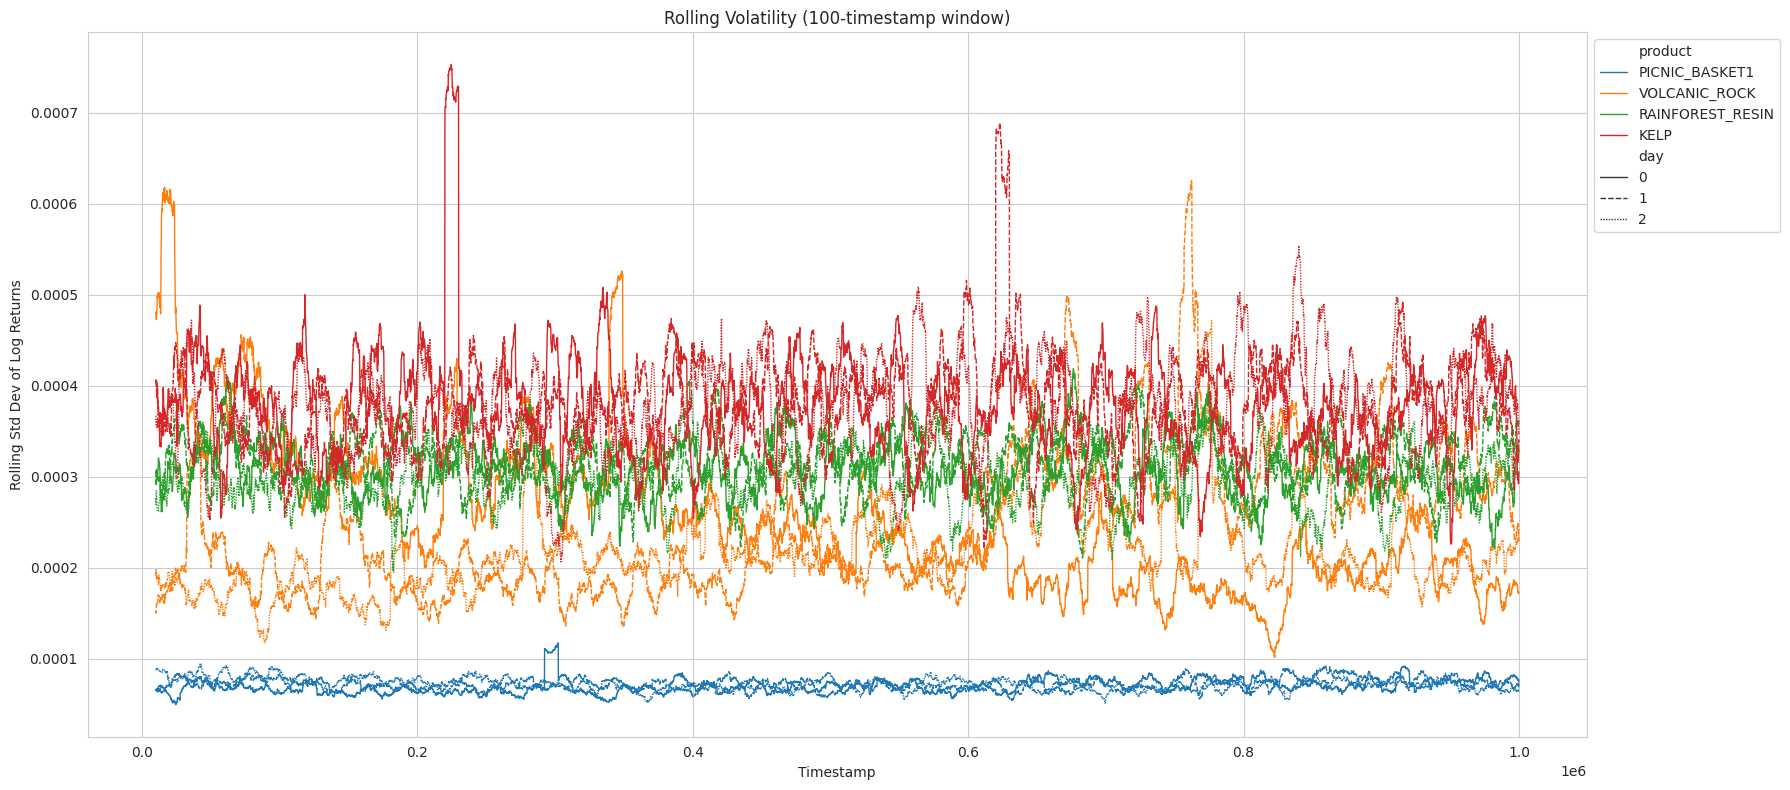


--- Average Rolling Volatility per Product ---
product
VOLCANIC_ROCK_VOUCHER_10500    0.035694
VOLCANIC_ROCK_VOUCHER_10250    0.014565
VOLCANIC_ROCK_VOUCHER_10000    0.010777
VOLCANIC_ROCK_VOUCHER_9750     0.004588
VOLCANIC_ROCK_VOUCHER_9500     0.003079
SQUID_INK                      0.000830
KELP                           0.000378
RAINFOREST_RESIN               0.000308
VOLCANIC_ROCK                  0.000240
CROISSANTS                     0.000090
PICNIC_BASKET2                 0.000084
JAMS                           0.000078
PICNIC_BASKET1                 0.000072
DJEMBES                        0.000064
Name: volatility, dtype: float64

--- Spread Analysis (ask_price_1 - bid_price_1) ---


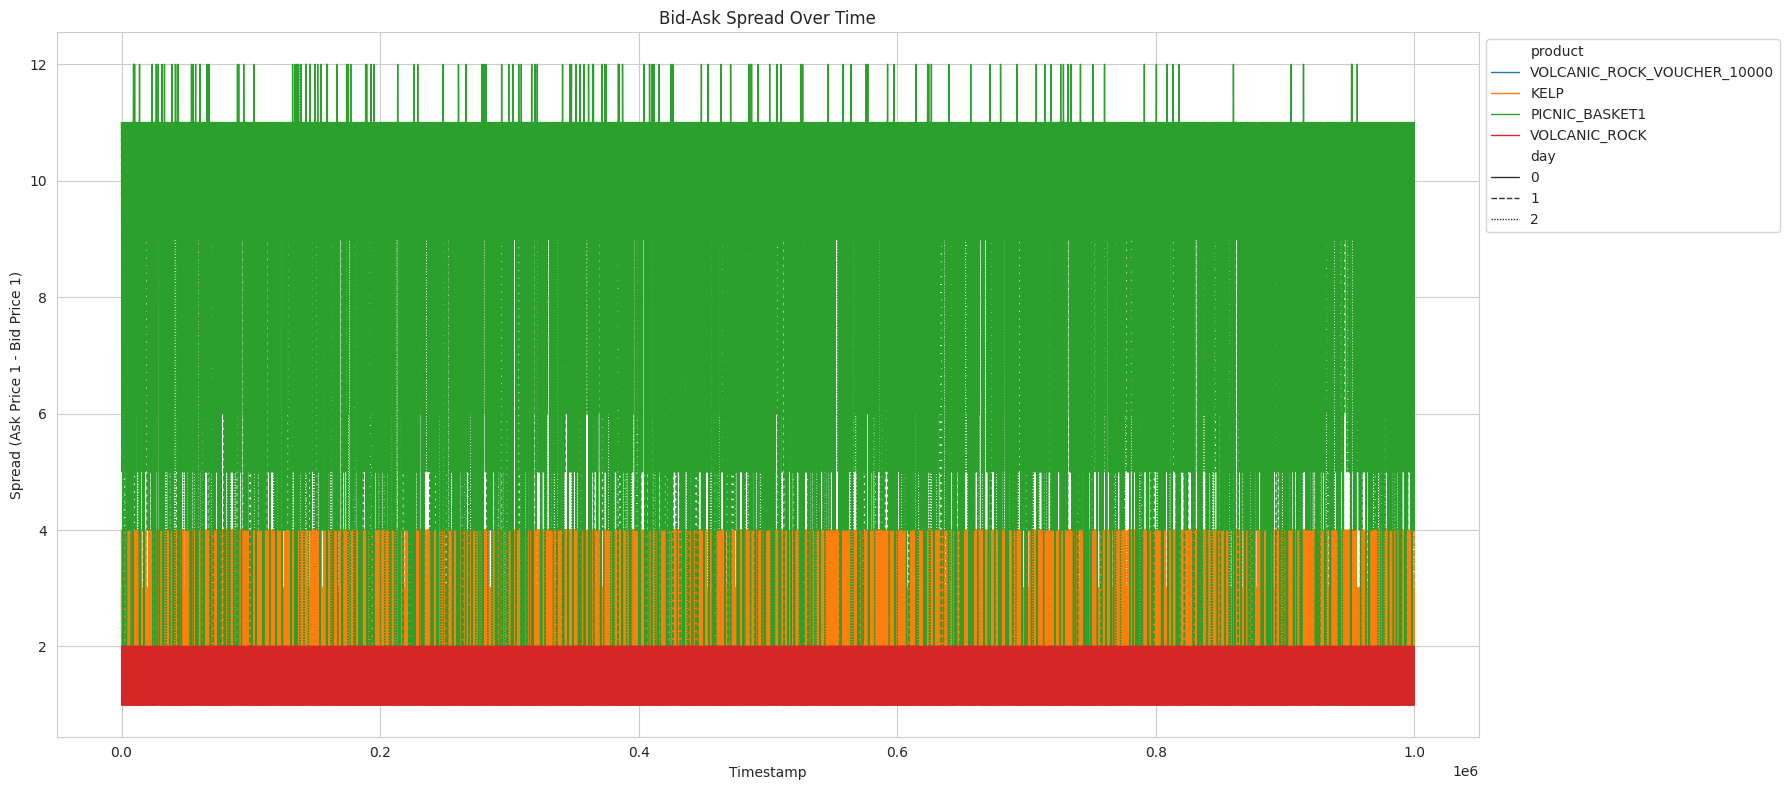


--- Average Spread per Product ---
product
RAINFOREST_RESIN               13.539200
PICNIC_BASKET1                  9.192867
PICNIC_BASKET2                  5.197600
KELP                            2.731100
SQUID_INK                       2.579467
JAMS                            1.617767
VOLCANIC_ROCK                   1.492200
DJEMBES                         1.264467
CROISSANTS                      1.205767
VOLCANIC_ROCK_VOUCHER_9500      1.118476
VOLCANIC_ROCK_VOUCHER_9750      1.083719
VOLCANIC_ROCK_VOUCHER_10000     1.047575
VOLCANIC_ROCK_VOUCHER_10250     1.020659
VOLCANIC_ROCK_VOUCHER_10500     1.005421
Name: spread, dtype: float64

Note: Spreads near 1 or 2 are common for highly liquid products, higher spreads indicate lower liquidity or higher volatility.

--- Log Return Distribution Analysis ---


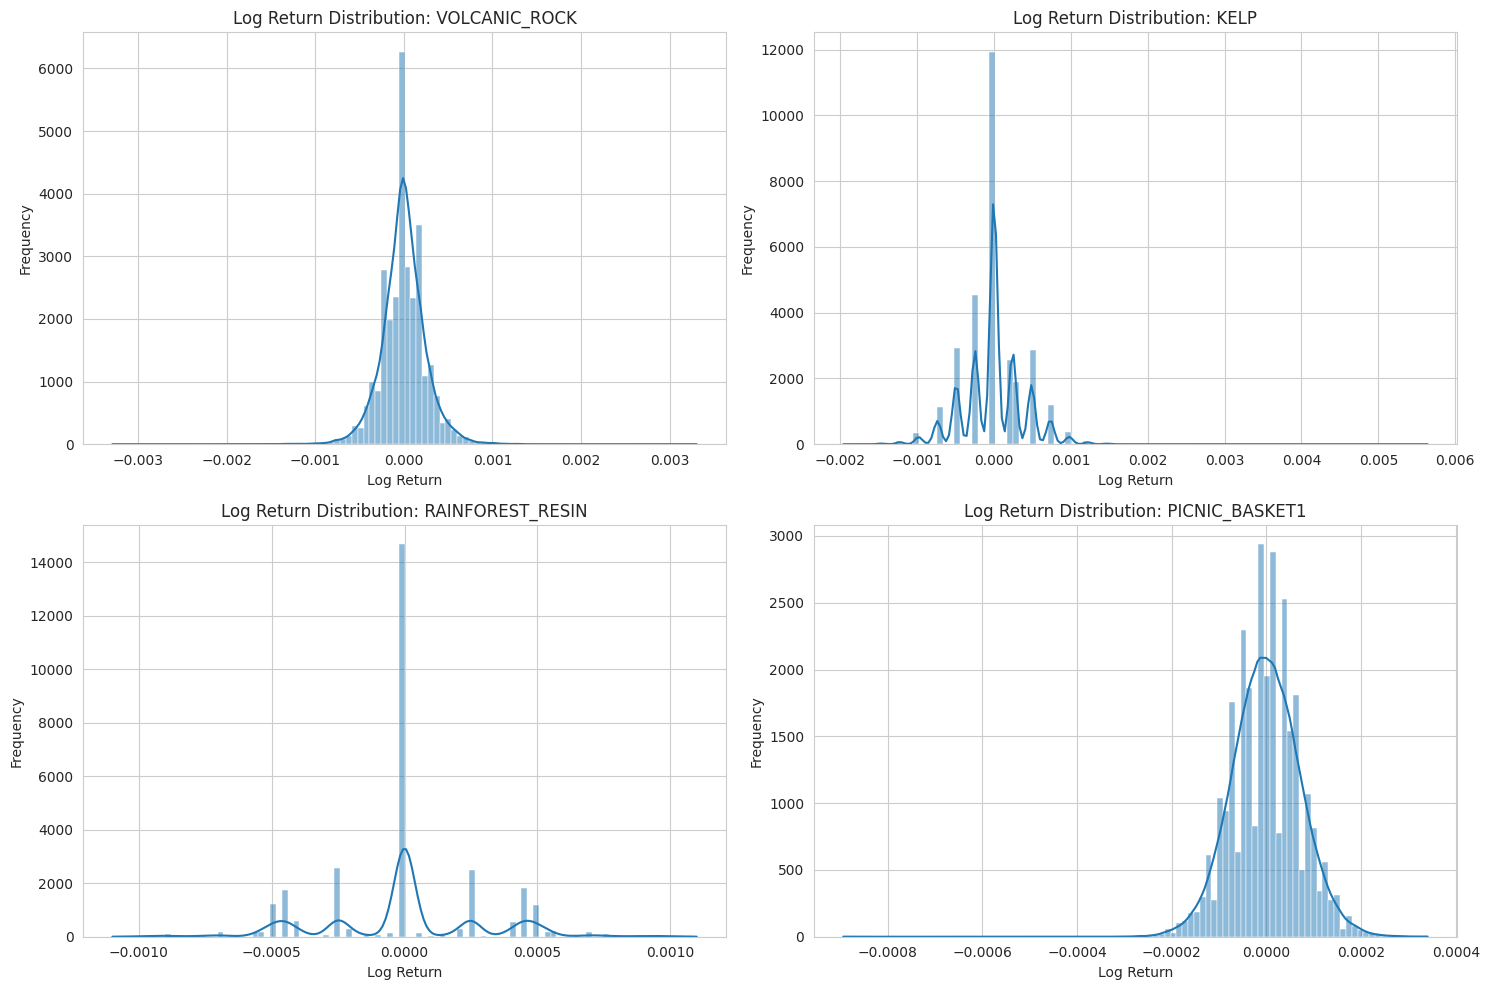


--- Normality Test (Shapiro-Wilk) for Log Returns (Sampled) ---
VOLCANIC_ROCK: Statistic=0.948, p-value=7.788e-39
  -> Reject normality (p < 0.05)
KELP: Statistic=0.940, p-value=5.246e-41
  -> Reject normality (p < 0.05)
RAINFOREST_RESIN: Statistic=0.921, p-value=2.160e-45
  -> Reject normality (p < 0.05)
PICNIC_BASKET1: Statistic=0.998, p-value=4.300e-07
  -> Reject normality (p < 0.05)

Note: Financial returns are typically not normally distributed (heavy tails).

--- Autocorrelation Analysis (Log Returns) ---


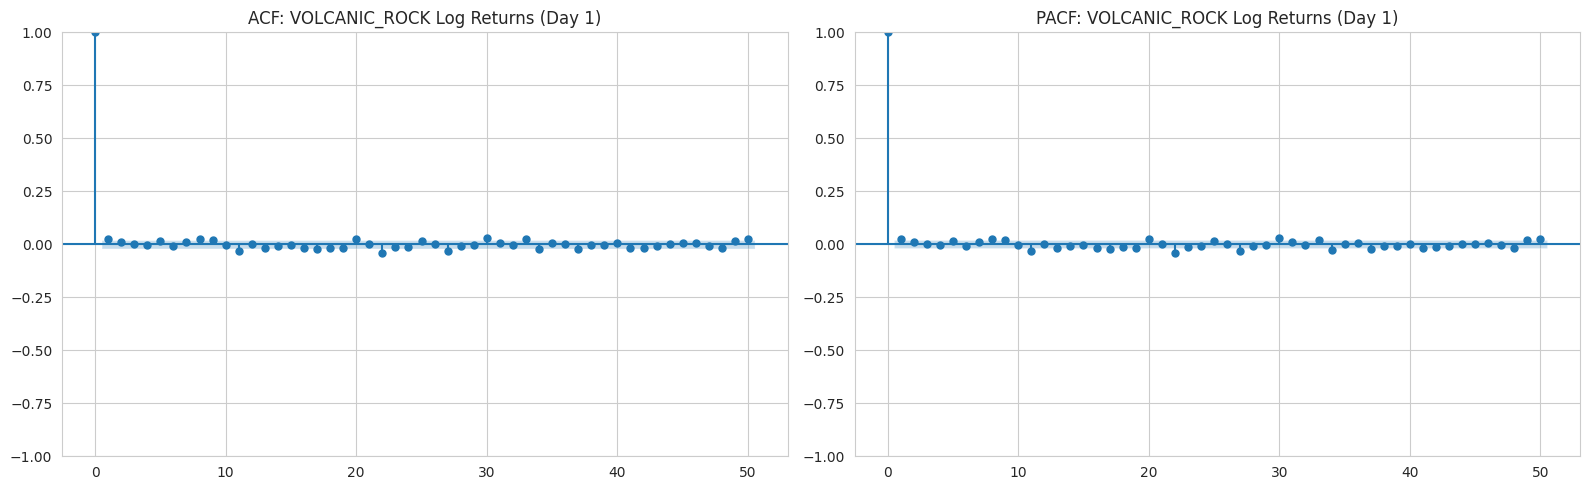


Analysis for VOLCANIC_ROCK on Day 1:
 - ACF shows the correlation of the series with its lags.
 - PACF shows the correlation after removing effects of intermediate lags.
 - Significant spikes suggest predictability based on past returns (e.g., mean reversion or momentum effects). Often, high-frequency returns show some short-term autocorrelation.

--- Intraday Pattern Analysis ---


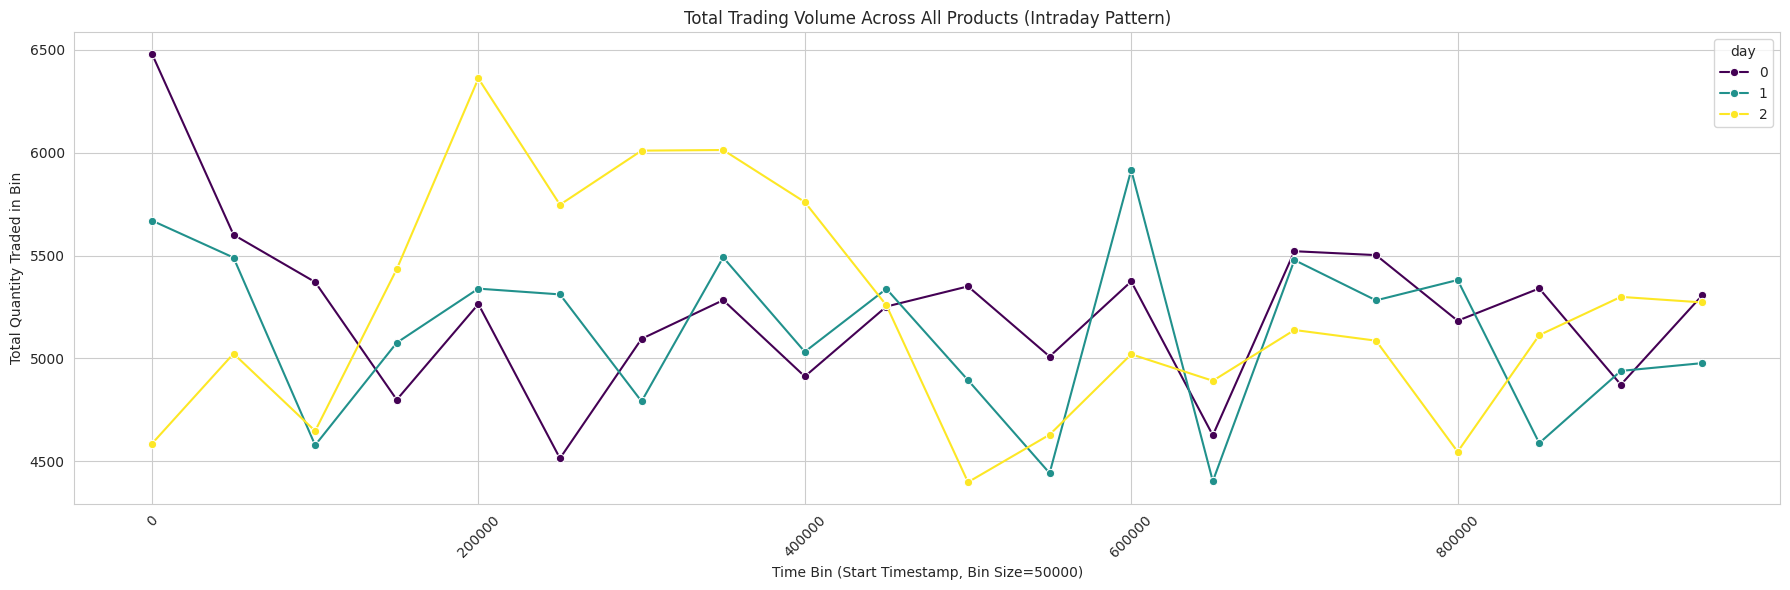


--- KELP Special Analysis ---


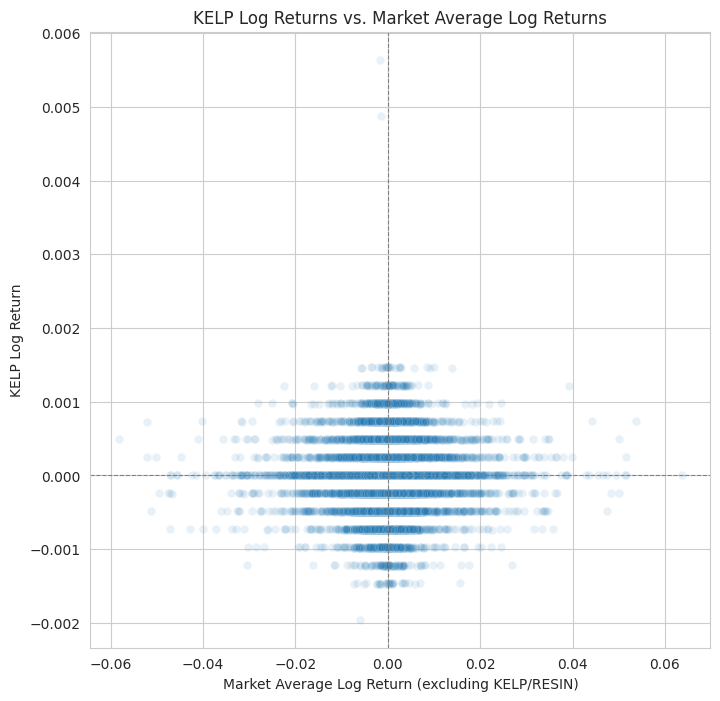


Correlation between KELP log returns and Market Average log returns: 0.0095
This confirms the negative relationship observed in the overall correlation matrix.

--- Order Book Imbalance Analysis ---


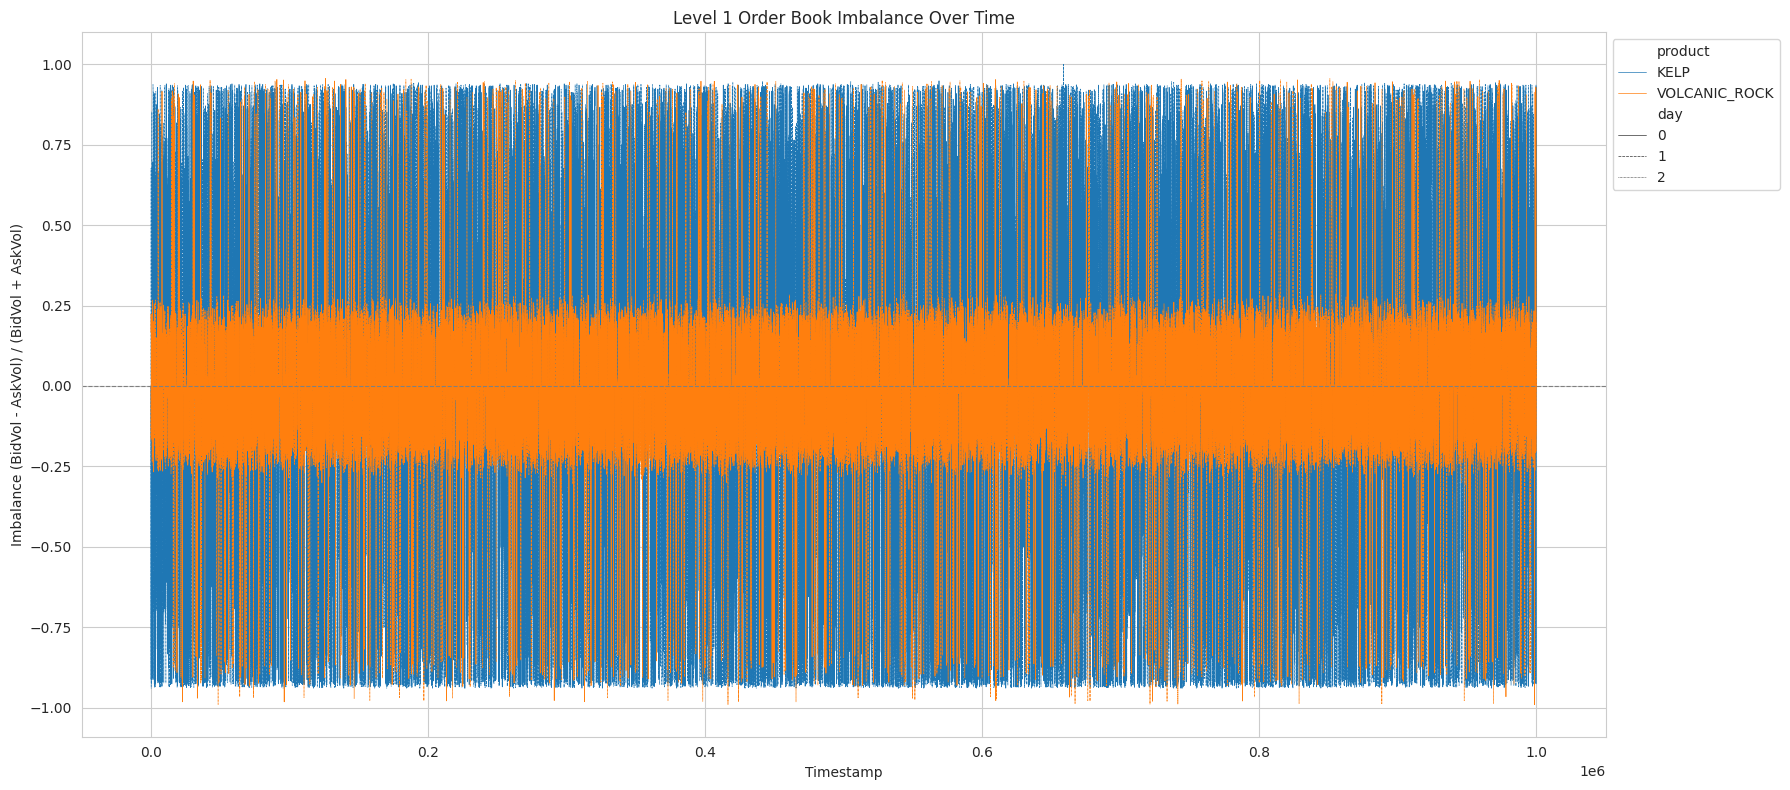


Imbalance values near +1 indicate strong buying pressure at best prices.
Imbalance values near -1 indicate strong selling pressure at best prices.
Values near 0 indicate a balanced book.
Further analysis could correlate imbalance with subsequent price changes (predictive power).

--- Trade Size Distribution Analysis ---


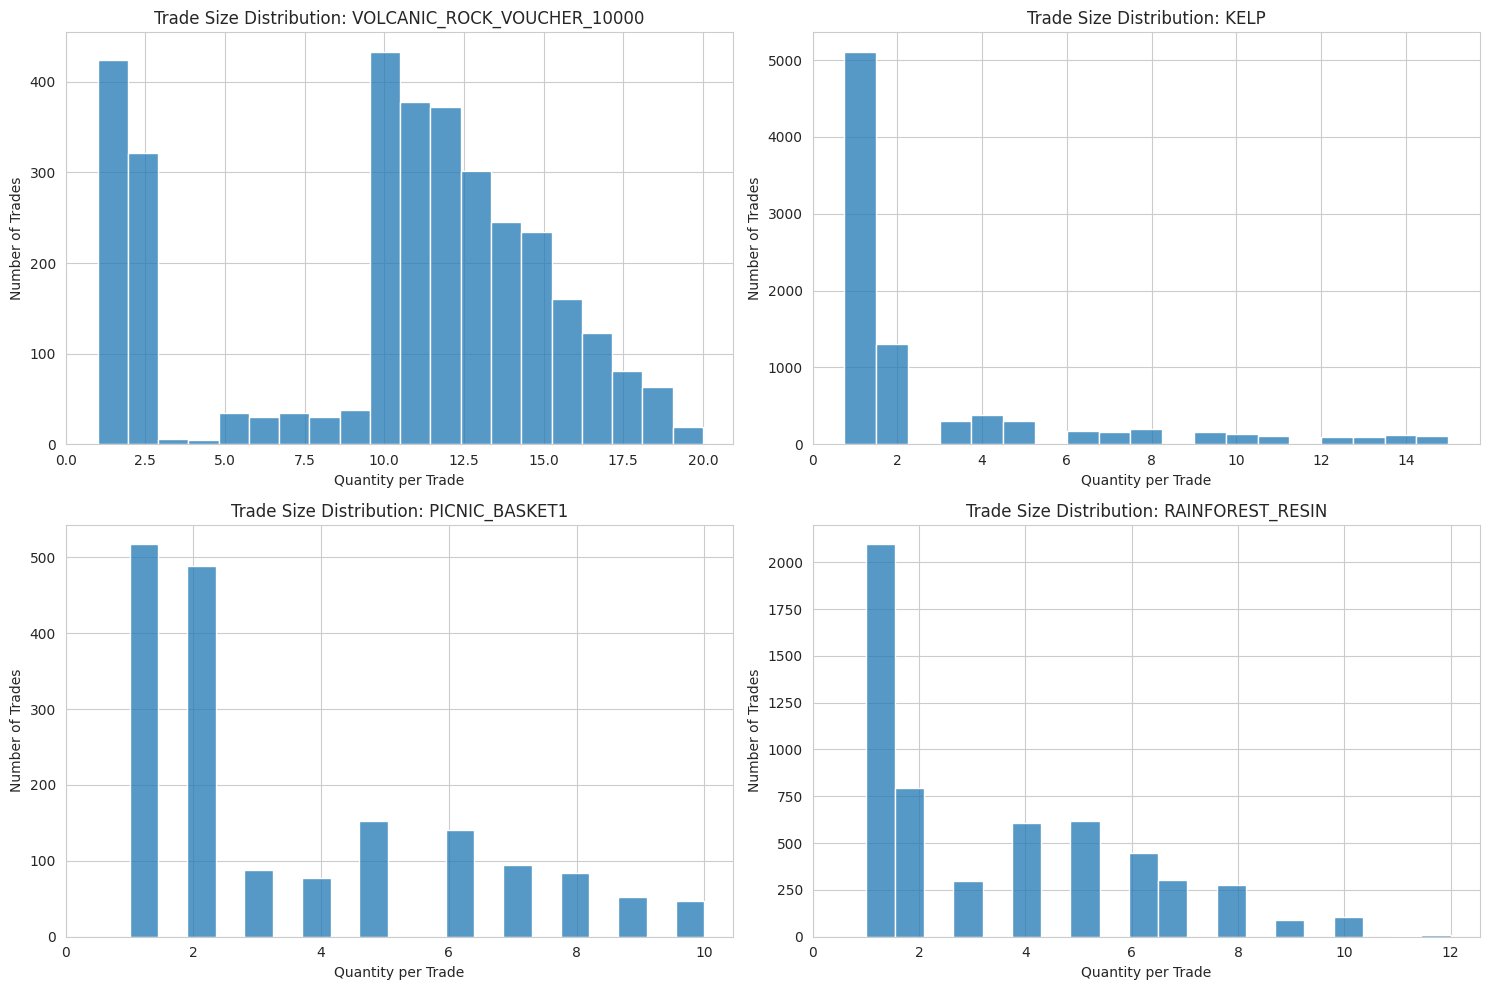


--- Average Trade Size per Product ---
symbol
VOLCANIC_ROCK_VOUCHER_10000    10.135914
VOLCANIC_ROCK_VOUCHER_9750     10.126552
VOLCANIC_ROCK_VOUCHER_10500    10.123996
VOLCANIC_ROCK_VOUCHER_10250    10.103394
VOLCANIC_ROCK_VOUCHER_9500     10.100583
JAMS                            7.059753
CROISSANTS                      6.642373
VOLCANIC_ROCK                   6.502041
PICNIC_BASKET2                  4.469790
PICNIC_BASKET1                  3.414802
DJEMBES                         3.388512
RAINFOREST_RESIN                3.383702
SQUID_INK                       2.863946
KELP                            2.855741
Name: quantity, dtype: float64

--- Volcanic Voucher Premium Deep Dive ---


<ipython-input-3-17d3180c8c53>:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcanic_pivot[intrinsic_value_col] = (volcanic_pivot[rock_price_col] - strike_price).clip(lower=0)
<ipython-input-3-17d3180c8c53>:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcanic_pivot[premium_col_name] = volcanic_pivot[voucher] - volcanic_pivot[intrinsic_value_col]
<ipython-input-3-17d3180c8c53>:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

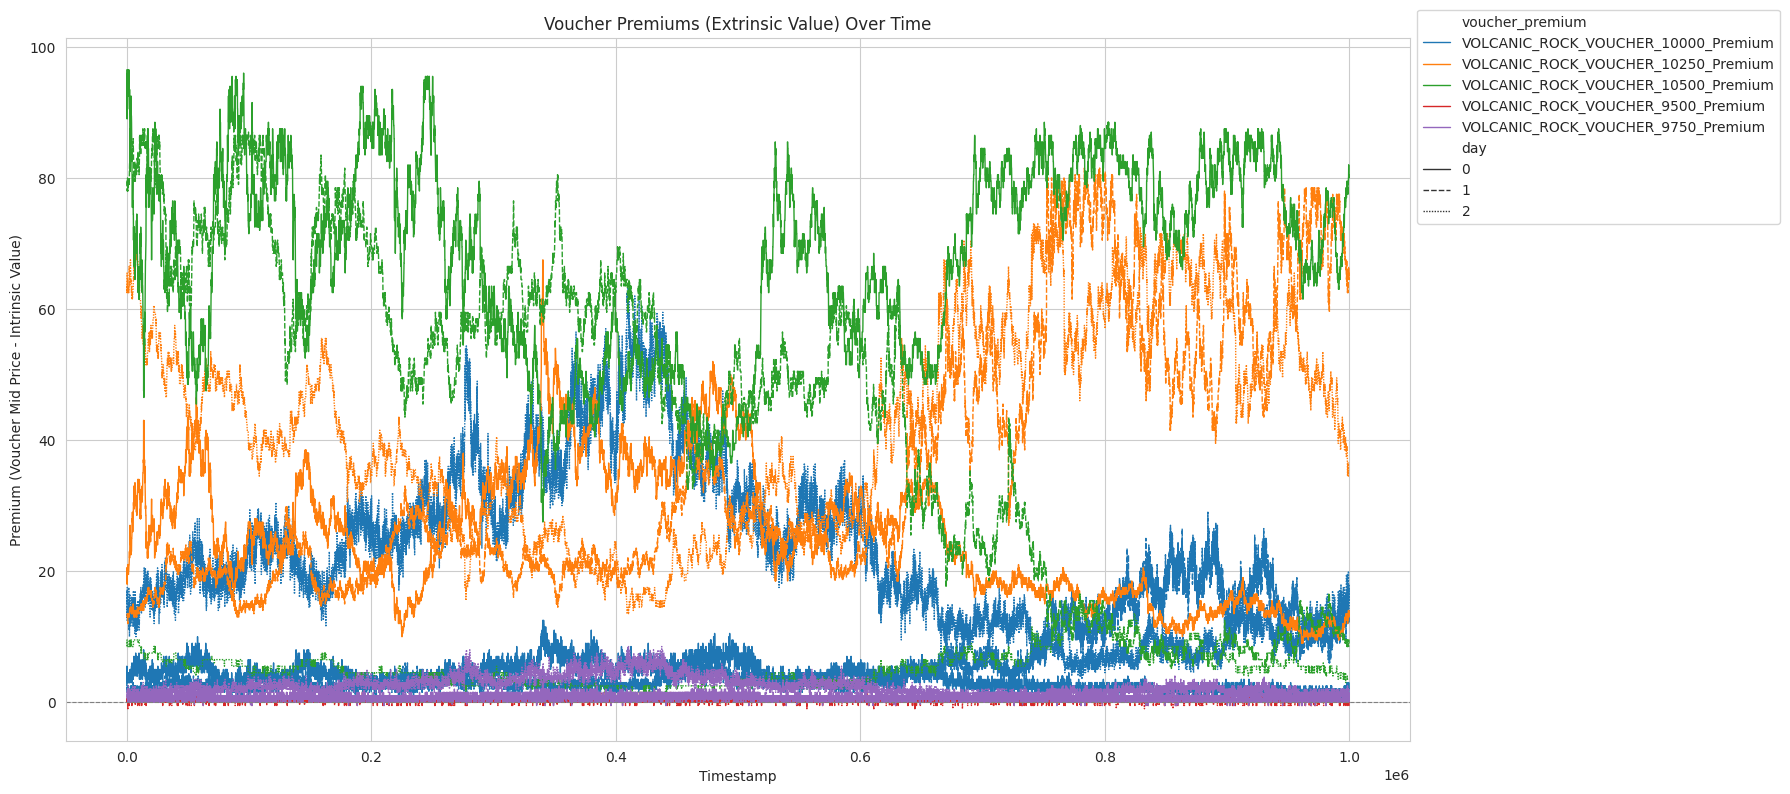



--- Further EDA Complete ---
Consider next steps like backtesting specific strategy ideas based on these findings.


In [ ]:
# @title Setup and Load Data (Assuming dataframes are available or reload)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Load Data Again (If needed in a new session) ---
# Make sure the CSV files are uploaded to your Colab environment
price_files = {
    0: 'prices_round_3_day_0.csv',
    1: 'prices_round_3_day_1.csv',
    2: 'prices_round_3_day_2.csv',
}
trade_files = {
    0: 'trades_round_3_day_0.csv',
    1: 'trades_round_3_day_1.csv',
    2: 'trades_round_3_day_2.csv',
}

price_dfs = []
for day, filename in price_files.items():
    try:
        df = pd.read_csv(filename, delimiter=';')
        df['day'] = day
        price_dfs.append(df)
    except FileNotFoundError:
        print(f"Warning: File not found - {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

trade_dfs = []
for day, filename in trade_files.items():
    try:
        df = pd.read_csv(filename, delimiter=';')
        df['day'] = day
        trade_dfs.append(df)
    except FileNotFoundError:
        print(f"Warning: File not found - {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

if price_dfs:
    prices_df = pd.concat(price_dfs, ignore_index=True).sort_values(by=['day', 'timestamp']).reset_index(drop=True)
    print(f"Combined Prices DataFrame Shape: {prices_df.shape}")
else:
    print("No price data loaded.")
    prices_df = pd.DataFrame()

if trade_dfs:
    trades_df = pd.concat(trade_dfs, ignore_index=True).sort_values(by=['day', 'timestamp']).reset_index(drop=True)
    print(f"Combined Trades DataFrame Shape: {trades_df.shape}")
else:
    print("No trade data loaded.")
    trades_df = pd.DataFrame()

# Set consistent plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
# Filter out potential placeholder PnL column if it exists and is always zero
if 'profit_and_loss' in prices_df.columns and prices_df['profit_and_loss'].nunique() == 1 and prices_df['profit_and_loss'].iloc[0] == 0:
    prices_df = prices_df.drop(columns=['profit_and_loss'])

print("\nSetup and Data Loading Complete.")

# @title Feature Engineering: Spread, Returns, Imbalance

if not prices_df.empty:
    print("\n--- Feature Engineering ---")
    # Calculate Bid-Ask Spread
    prices_df['spread'] = prices_df['ask_price_1'] - prices_df['bid_price_1']

    # Calculate Log Returns (handle potential zeros/negatives in mid_price if any)
    # Group by product and day to calculate returns correctly
    prices_df['mid_price_lag'] = prices_df.groupby(['day', 'product'])['mid_price'].shift(1)
    # Avoid division by zero or log(0)
    prices_df['log_return'] = np.log(prices_df['mid_price'] / prices_df['mid_price_lag']).replace([np.inf, -np.inf], np.nan)

    # Calculate Order Book Imbalance (Level 1)
    # Avoid division by zero if both bid/ask volumes are zero
    prices_df['book_imbalance'] = (prices_df['bid_volume_1'] - prices_df['ask_volume_1']) / \
                                   (prices_df['bid_volume_1'] + prices_df['ask_volume_1']).replace(0, np.nan) # Avoid division by zero

    # Calculate Volatility (Rolling Standard Deviation of Log Returns)
    # Define rolling window size (e.g., 100 timestamps = 10 seconds if 100ms steps)
    window_size = 100
    prices_df['volatility'] = prices_df.groupby(['day', 'product'])['log_return'].transform(lambda x: x.rolling(window=window_size).std())

    print("Features calculated: spread, log_return, book_imbalance, volatility")
    print(prices_df[['product', 'timestamp', 'mid_price', 'spread', 'log_return', 'book_imbalance', 'volatility']].head())
    print("\nChecking for NaNs introduced:")
    print(prices_df[['spread', 'log_return', 'book_imbalance', 'volatility']].isnull().sum())
else:
    print("Prices DataFrame is empty, skipping feature engineering.")


# @title Volatility Analysis

if not prices_df.empty and 'volatility' in prices_df.columns:
    print("\n--- Volatility Analysis (Rolling Std Dev of Log Returns) ---")

    products_to_plot = ['VOLCANIC_ROCK', 'KELP', 'RAINFOREST_RESIN', 'PICNIC_BASKET1'] # Example products
    volatility_data = prices_df[prices_df['product'].isin(products_to_plot)].dropna(subset=['volatility'])

    plt.figure(figsize=(18, 8))
    sns.lineplot(data=volatility_data, x='timestamp', y='volatility', hue='product', style='day', lw=1)
    plt.title(f'Rolling Volatility ({window_size}-timestamp window)')
    plt.xlabel('Timestamp')
    plt.ylabel('Rolling Std Dev of Log Returns')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Compare average volatility across products
    avg_volatility = prices_df.groupby('product')['volatility'].mean().sort_values(ascending=False)
    print("\n--- Average Rolling Volatility per Product ---")
    print(avg_volatility)

else:
    print("Skipping volatility analysis as data is missing.")

# @title Spread Analysis

if not prices_df.empty and 'spread' in prices_df.columns:
    print("\n--- Spread Analysis (ask_price_1 - bid_price_1) ---")

    # Plot spread over time for a few interesting products
    products_to_plot = ['VOLCANIC_ROCK', 'KELP', 'PICNIC_BASKET1', 'VOLCANIC_ROCK_VOUCHER_10000']
    spread_data = prices_df[prices_df['product'].isin(products_to_plot)].dropna(subset=['spread'])

    plt.figure(figsize=(18, 8))
    sns.lineplot(data=spread_data, x='timestamp', y='spread', hue='product', style='day', lw=1)
    plt.title('Bid-Ask Spread Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Spread (Ask Price 1 - Bid Price 1)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.ylim(0, 20) # Adjust ylim if needed for better visualization
    plt.tight_layout()
    plt.show()

    # Compare average spread across products
    avg_spread = prices_df.groupby('product')['spread'].mean().sort_values(ascending=False)
    print("\n--- Average Spread per Product ---")
    print(avg_spread)
    print("\nNote: Spreads near 1 or 2 are common for highly liquid products, higher spreads indicate lower liquidity or higher volatility.")

else:
     print("Skipping spread analysis as data is missing.")

# @title Return Distribution Analysis

if not prices_df.empty and 'log_return' in prices_df.columns:
    print("\n--- Log Return Distribution Analysis ---")

    # Focus on a few key products
    products_to_analyze = ['VOLCANIC_ROCK', 'KELP', 'RAINFOREST_RESIN', 'PICNIC_BASKET1']
    returns_data = prices_df[prices_df['product'].isin(products_to_analyze)].dropna(subset=['log_return'])

    plt.figure(figsize=(15, 10))
    for i, product in enumerate(products_to_analyze):
        plt.subplot(2, 2, i + 1)
        sns.histplot(returns_data[returns_data['product'] == product]['log_return'], kde=True, bins=100)
        plt.title(f'Log Return Distribution: {product}')
        plt.xlabel('Log Return')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Normality Tests (Shapiro-Wilk) - Use a sample for performance if data is large
    print("\n--- Normality Test (Shapiro-Wilk) for Log Returns (Sampled) ---")
    for product in products_to_analyze:
        # Sample ~5000 points to avoid Shapiro test limitations/performance issues
        sample_data = returns_data[returns_data['product'] == product]['log_return'].sample(n=min(5000, len(returns_data[returns_data['product'] == product])), random_state=1)
        if len(sample_data) > 3: # Shapiro requires at least 3 samples
            stat, p_value = stats.shapiro(sample_data)
            print(f"{product}: Statistic={stat:.3f}, p-value={p_value:.3e}")
            if p_value < 0.05:
                print(f"  -> Reject normality (p < 0.05)")
            else:
                print(f"  -> Cannot reject normality (p >= 0.05)")
        else:
             print(f"{product}: Not enough data points for Shapiro test.")
    print("\nNote: Financial returns are typically not normally distributed (heavy tails).")

else:
    print("Skipping return distribution analysis as data is missing.")

# @title Autocorrelation Analysis (Log Returns)

if not prices_df.empty and 'log_return' in prices_df.columns:
    print("\n--- Autocorrelation Analysis (Log Returns) ---")

    # Focus on one or two products, potentially for a single day for clarity
    product_acf = 'VOLCANIC_ROCK'
    day_acf = 1
    acf_data = prices_df[(prices_df['product'] == product_acf) & (prices_df['day'] == day_acf)]['log_return'].dropna()

    if len(acf_data) > 20: # Need sufficient data points
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        plot_acf(acf_data, lags=50, ax=axes[0], title=f'ACF: {product_acf} Log Returns (Day {day_acf})')
        plot_pacf(acf_data, lags=50, ax=axes[1], title=f'PACF: {product_acf} Log Returns (Day {day_acf})', method='ywm') # Use 'ywm' or 'ols'
        plt.tight_layout()
        plt.show()
        print(f"\nAnalysis for {product_acf} on Day {day_acf}:")
        print(" - ACF shows the correlation of the series with its lags.")
        print(" - PACF shows the correlation after removing effects of intermediate lags.")
        print(" - Significant spikes suggest predictability based on past returns (e.g., mean reversion or momentum effects). Often, high-frequency returns show some short-term autocorrelation.")

    else:
        print(f"Not enough data points for ACF/PACF analysis for {product_acf} on Day {day_acf}.")

else:
    print("Skipping autocorrelation analysis as data is missing.")


# @title Intraday Pattern Analysis (Example: Volume)

if not prices_df.empty and not trades_df.empty:
    print("\n--- Intraday Pattern Analysis ---")
    # Create time bins (e.g., every 50000 timestamps = 50 seconds)
    time_bin_size = 50000
    trades_df['time_bin'] = (trades_df['timestamp'] // time_bin_size) * time_bin_size

    # Aggregate Trade Volume per bin per day
    intraday_volume = trades_df.groupby(['day', 'time_bin'])['quantity'].sum().reset_index()

    plt.figure(figsize=(18, 6))
    sns.lineplot(data=intraday_volume, x='time_bin', y='quantity', hue='day', palette='viridis', marker='o', linestyle='-')
    plt.title('Total Trading Volume Across All Products (Intraday Pattern)')
    plt.xlabel(f'Time Bin (Start Timestamp, Bin Size={time_bin_size})')
    plt.ylabel('Total Quantity Traded in Bin')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # You could do similar analysis for volatility or spread using prices_df

else:
    print("Skipping intraday pattern analysis as data is missing.")

# @title KELP vs Market Average Analysis

if not prices_df.empty:
    print("\n--- KELP Special Analysis ---")
    # Calculate a simple 'market average' log return (excluding KELP, RESIN)
    market_products = [p for p in prices_df['product'].unique() if p not in ['KELP', 'RAINFOREST_RESIN']]
    market_returns = prices_df[prices_df['product'].isin(market_products)].groupby(['day', 'timestamp'])['log_return'].mean().reset_index()
    market_returns.rename(columns={'log_return': 'market_log_return'}, inplace=True)

    # Get KELP returns
    kelp_returns = prices_df[prices_df['product'] == 'KELP'][['day', 'timestamp', 'log_return']].rename(columns={'log_return': 'kelp_log_return'})

    # Merge
    comparison_df = pd.merge(kelp_returns, market_returns, on=['day', 'timestamp'], how='inner').dropna()

    if not comparison_df.empty:
        # Scatter plot of returns
        plt.figure(figsize=(8, 8))
        sns.scatterplot(data=comparison_df, x='market_log_return', y='kelp_log_return', alpha=0.1)
        plt.title('KELP Log Returns vs. Market Average Log Returns')
        plt.xlabel('Market Average Log Return (excluding KELP/RESIN)')
        plt.ylabel('KELP Log Return')
        plt.axhline(0, color='grey', linestyle='--', lw=0.8)
        plt.axvline(0, color='grey', linestyle='--', lw=0.8)
        plt.show()

        correlation = comparison_df['kelp_log_return'].corr(comparison_df['market_log_return'])
        print(f"\nCorrelation between KELP log returns and Market Average log returns: {correlation:.4f}")
        print("This confirms the negative relationship observed in the overall correlation matrix.")
    else:
        print("Could not create comparison dataframe for KELP vs Market Average.")

else:
     print("Skipping KELP analysis as data is missing.")


# @title Order Book Imbalance Analysis

if not prices_df.empty and 'book_imbalance' in prices_df.columns:
    print("\n--- Order Book Imbalance Analysis ---")

    products_to_plot = ['VOLCANIC_ROCK', 'KELP']
    imbalance_data = prices_df[prices_df['product'].isin(products_to_plot)].dropna(subset=['book_imbalance'])

    plt.figure(figsize=(18, 8))
    sns.lineplot(data=imbalance_data, x='timestamp', y='book_imbalance', hue='product', style='day', lw=0.5)
    plt.title('Level 1 Order Book Imbalance Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Imbalance (BidVol - AskVol) / (BidVol + AskVol)')
    plt.axhline(0, color='grey', linestyle='--', lw=0.8)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    print("\nImbalance values near +1 indicate strong buying pressure at best prices.")
    print("Imbalance values near -1 indicate strong selling pressure at best prices.")
    print("Values near 0 indicate a balanced book.")
    print("Further analysis could correlate imbalance with subsequent price changes (predictive power).")

else:
    print("Skipping order book imbalance analysis as data is missing.")


# @title Trade Size Distribution

if not trades_df.empty:
    print("\n--- Trade Size Distribution Analysis ---")

    products_to_analyze = ['VOLCANIC_ROCK_VOUCHER_10000', 'KELP', 'PICNIC_BASKET1', 'RAINFOREST_RESIN']
    trade_size_data = trades_df[trades_df['symbol'].isin(products_to_analyze)]

    plt.figure(figsize=(15, 10))
    for i, product in enumerate(products_to_analyze):
        plt.subplot(2, 2, i + 1)
        sns.histplot(trade_size_data[trade_size_data['symbol'] == product]['quantity'], bins=20, kde=False) # Max quantity seems around 20 based on head
        plt.title(f'Trade Size Distribution: {product}')
        plt.xlabel('Quantity per Trade')
        plt.ylabel('Number of Trades')
        plt.xlim(left=0) # Ensure x-axis starts at 0
    plt.tight_layout()
    plt.show()

    avg_trade_size = trades_df.groupby('symbol')['quantity'].mean().sort_values(ascending=False)
    print("\n--- Average Trade Size per Product ---")
    print(avg_trade_size)

else:
    print("Skipping trade size analysis as trade data is missing.")


# @title Voucher Premium Deep Dive (All Vouchers)

if not prices_df.empty and 'VOLCANIC_ROCK' in prices_df['product'].unique():
    print("\n--- Volcanic Voucher Premium Deep Dive ---")
    # Pivot data for easier comparison (reuse from previous EDA if available)
    mid_prices_pivot = prices_df.pivot_table(index=['day', 'timestamp'], columns='product', values='mid_price')

    # Select only volcanic items
    volcanic_items = sorted([p for p in prices_df['product'].unique() if 'VOLCANIC' in p])
    volcanic_pivot = mid_prices_pivot[[col for col in volcanic_items if col in mid_prices_pivot.columns]]

    if 'VOLCANIC_ROCK' in volcanic_pivot.columns:
        rock_price_col = 'VOLCANIC_ROCK'
        voucher_cols = [col for col in volcanic_pivot.columns if 'VOUCHER' in col]
        premium_cols = []

        # Recalculate premiums for all vouchers
        for voucher in voucher_cols:
            try:
                strike_price = int(voucher.split('_')[-1])
                intrinsic_value_col = f'{voucher}_Intrinsic_Call'
                premium_col_name = f'{voucher}_Premium' # Shorter name
                premium_cols.append(premium_col_name)

                volcanic_pivot[intrinsic_value_col] = (volcanic_pivot[rock_price_col] - strike_price).clip(lower=0)
                volcanic_pivot[premium_col_name] = volcanic_pivot[voucher] - volcanic_pivot[intrinsic_value_col]
            except (ValueError, KeyError) as e:
                 print(f"Skipping premium calculation for {voucher}: {e}")

        # Plot premiums over time
        if premium_cols:
            premium_data_to_plot = volcanic_pivot[premium_cols].reset_index()
            premium_melted = premium_data_to_plot.melt(id_vars=['day', 'timestamp'], var_name='voucher_premium', value_name='premium_value')

            plt.figure(figsize=(18, 8))
            sns.lineplot(data=premium_melted, x='timestamp', y='premium_value', hue='voucher_premium', style='day', lw=1)
            plt.title('Voucher Premiums (Extrinsic Value) Over Time')
            plt.xlabel('Timestamp')
            plt.ylabel('Premium (Voucher Mid Price - Intrinsic Value)')
            plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1.05)) # Adjust legend position
            plt.tight_layout()
            plt.show()
        else:
            print("No premium columns were successfully calculated.")
    else:
        print("VOLCANIC_ROCK data not found in pivoted prices for premium analysis.")

else:
    print("Skipping voucher premium deep dive as essential data is missing.")


print("\n\n--- Further EDA Complete ---")
print("Consider next steps like backtesting specific strategy ideas based on these findings.")


--- Starting Grid Search for MA Crossover ---


Optimizing Products:   0%|          | 0/14 [00:00<?, ?it/s]


--- Grid Search Complete ---

--- Best Parameters Found (Based on Total Hypothetical Log Return) ---
VOLCANIC_ROCK_VOUCHER_10500: Short Window=45, Long Window=70, PnL=-17.8656
DJEMBES: Short Window=5, Long Window=20, PnL=0.0365
CROISSANTS: Short Window=10, Long Window=40, PnL=0.0094
JAMS: Short Window=5, Long Window=60, PnL=0.0329
VOLCANIC_ROCK_VOUCHER_10000: Short Window=10, Long Window=20, PnL=-0.5024
KELP: Short Window=50, Long Window=90, PnL=-0.1428
VOLCANIC_ROCK_VOUCHER_9750: Short Window=5, Long Window=20, PnL=3.6598
PICNIC_BASKET1: Short Window=50, Long Window=60, PnL=0.0157
PICNIC_BASKET2: Short Window=20, Long Window=50, PnL=0.0048
VOLCANIC_ROCK_VOUCHER_9500: Short Window=5, Long Window=20, PnL=2.5219
RAINFOREST_RESIN: Short Window=35, Long Window=40, PnL=-0.2638
VOLCANIC_ROCK_VOUCHER_10250: Short Window=5, Long Window=20, PnL=7.9375
SQUID_INK: Short Window=10, Long Window=30, PnL=0.3220
VOLCANIC_ROCK: Short Window=5, Long Window=20, PnL=0.1834


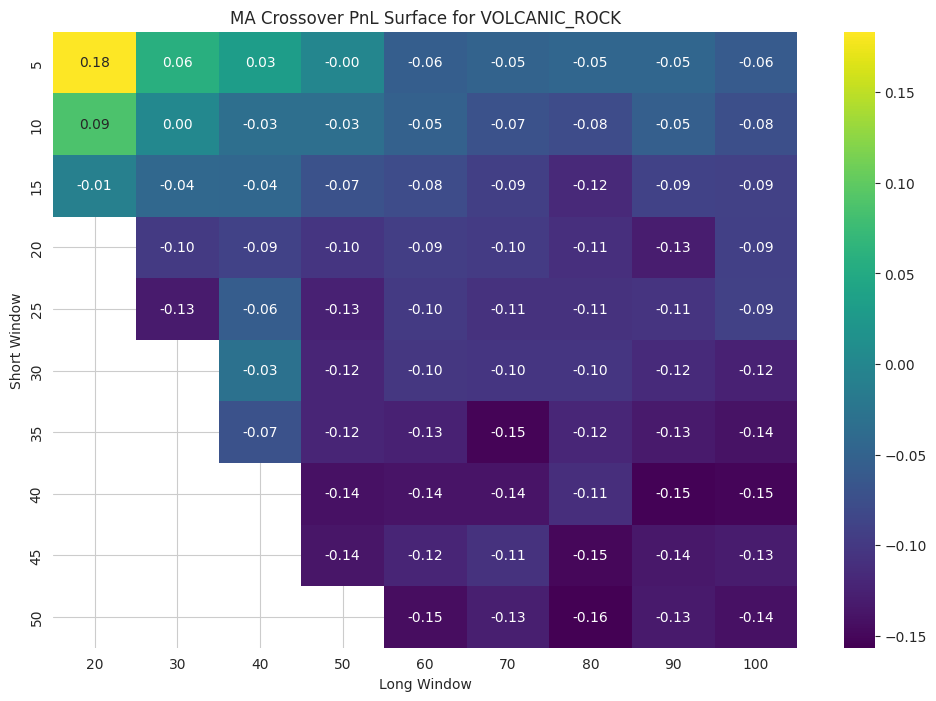


Reminder: These results are in-sample and ignore costs/slippage. Use for guidance only.


In [ ]:
# @title Parameter Optimization: Moving Average Crossover (Grid Search Example)

import itertools
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab

def run_ma_crossover_backtest(data, short_window, long_window):
    """
    Runs a simple Moving Average Crossover backtest.
    Returns hypothetical total log return (ignoring costs/slippage).
    """
    if long_window <= short_window:
        return -np.inf # Invalid parameter combination

    # Calculate Moving Averages using mid_price
    data = data.assign(
        short_ma = data['mid_price'].rolling(window=short_window).mean(),
        long_ma = data['mid_price'].rolling(window=long_window).mean()
    )

    # Generate Signals
    # Signal = 1 if short_ma > long_ma (Buy/Hold Long)
    # Signal = -1 if short_ma < long_ma (Sell/Hold Short)
    data['signal'] = 0
    data.loc[data['short_ma'] > data['long_ma'], 'signal'] = 1
    data.loc[data['short_ma'] < data['long_ma'], 'signal'] = -1

    # Calculate hypothetical 'position' (signal from the previous step)
    data['position'] = data['signal'].shift(1).fillna(0)

    # Calculate hypothetical strategy log returns
    # Assumes you take the position based on previous signal and hold for one period
    # Uses the pre-calculated log_return column
    data['strategy_log_return'] = data['position'] * data['log_return']

    # Calculate total hypothetical log return
    total_log_return = data['strategy_log_return'].sum()

    # Basic check for realistic returns (avoid huge numbers from errors)
    if not np.isfinite(total_log_return):
        return -np.inf

    return total_log_return


# --- Grid Search Setup ---
products_to_optimize = prices_df['product'].unique() # Optimize for all products

# Define parameter ranges (adjust these based on time scale and intuition)
short_window_range = range(5, 51, 5)    # e.g., 5, 10, 15... 50 timestamps
long_window_range = range(20, 101, 10) # e.g., 20, 30, 40... 100 timestamps

best_params = {}
results_log = {}

# --- Run Grid Search ---
print("\n--- Starting Grid Search for MA Crossover ---")

# Use tqdm for progress bar
for product in tqdm(products_to_optimize, desc="Optimizing Products"):
    product_data = prices_df[prices_df['product'] == product].copy()

    # Need log returns calculated for the backtest function
    if 'log_return' not in product_data.columns or product_data['log_return'].isnull().all():
         product_data['mid_price_lag'] = product_data.groupby('day')['mid_price'].shift(1)
         product_data['log_return'] = np.log(product_data['mid_price'] / product_data['mid_price_lag']).replace([np.inf, -np.inf], np.nan)

    product_data = product_data.dropna(subset=['mid_price', 'log_return']) # Ensure data needed is present

    if len(product_data) < max(long_window_range): # Check if enough data for longest MA
        print(f"Skipping {product}: Not enough data ({len(product_data)} rows)")
        continue

    best_pnl = -np.inf
    current_best_param = None
    product_results = []

    # Create combinations, ensuring short_window < long_window
    param_combinations = [
        (sw, lw) for sw in short_window_range for lw in long_window_range if sw < lw
    ]

    for sw, lw in param_combinations:
        pnl = run_ma_crossover_backtest(product_data, sw, lw)
        product_results.append({'sw': sw, 'lw': lw, 'pnl': pnl})

        if pnl > best_pnl:
            best_pnl = pnl
            current_best_param = {'sw': sw, 'lw': lw, 'pnl': pnl}

    best_params[product] = current_best_param
    results_log[product] = pd.DataFrame(product_results) # Store all results for later inspection

print("\n--- Grid Search Complete ---")

# --- Display Best Parameters Found (In-Sample) ---
print("\n--- Best Parameters Found (Based on Total Hypothetical Log Return) ---")
for product, params in best_params.items():
    if params:
        print(f"{product}: Short Window={params['sw']}, Long Window={params['lw']}, PnL={params['pnl']:.4f}")
    else:
        print(f"{product}: No valid parameters found or optimization skipped.")

# --- Example: Plot PnL Surface for one product ---
example_product = 'VOLCANIC_ROCK'
if example_product in results_log and not results_log[example_product].empty:
    try:
        pnl_pivot = results_log[example_product].pivot_table(index='sw', columns='lw', values='pnl')
        plt.figure(figsize=(12, 8))
        sns.heatmap(pnl_pivot, annot=True, fmt=".2f", cmap="viridis")
        plt.title(f'MA Crossover PnL Surface for {example_product}')
        plt.xlabel('Long Window')
        plt.ylabel('Short Window')
        plt.show()
    except Exception as e:
        print(f"Could not plot heatmap for {example_product}: {e}")
        print("Pivot table data:")
        print(results_log[example_product].head())

print("\nReminder: These results are in-sample and ignore costs/slippage. Use for guidance only.")

Please upload the 6 CSV files (prices_round_3_day_X.csv and trades_round_3_day_X.csv)


Saving prices_round_3_day_0.csv to prices_round_3_day_0.csv
Saving prices_round_3_day_1.csv to prices_round_3_day_1.csv
Saving prices_round_3_day_2.csv to prices_round_3_day_2.csv
Saving trades_round_3_day_0.csv to trades_round_3_day_0.csv
Saving trades_round_3_day_1.csv to trades_round_3_day_1.csv
Saving trades_round_3_day_2.csv to trades_round_3_day_2.csv
Loading prices_round_3_day_0.csv...
Loaded prices_round_3_day_0.csv shape: (140000, 17)
Loading trades_round_3_day_0.csv...
Loaded trades_round_3_day_0.csv shape: (18123, 8)
Loading prices_round_3_day_1.csv...
Loaded prices_round_3_day_1.csv shape: (140000, 17)
Loading trades_round_3_day_1.csv...
Loaded trades_round_3_day_1.csv shape: (18000, 8)
Loading prices_round_3_day_2.csv...
Loaded prices_round_3_day_2.csv shape: (140000, 17)
Loading trades_round_3_day_2.csv...
Loaded trades_round_3_day_2.csv shape: (17901, 8)

Combined Prices DataFrame shape: (420000, 17)
Prices columns: ['day', 'timestamp', 'product', 'bid_price_1', 'bid_vol

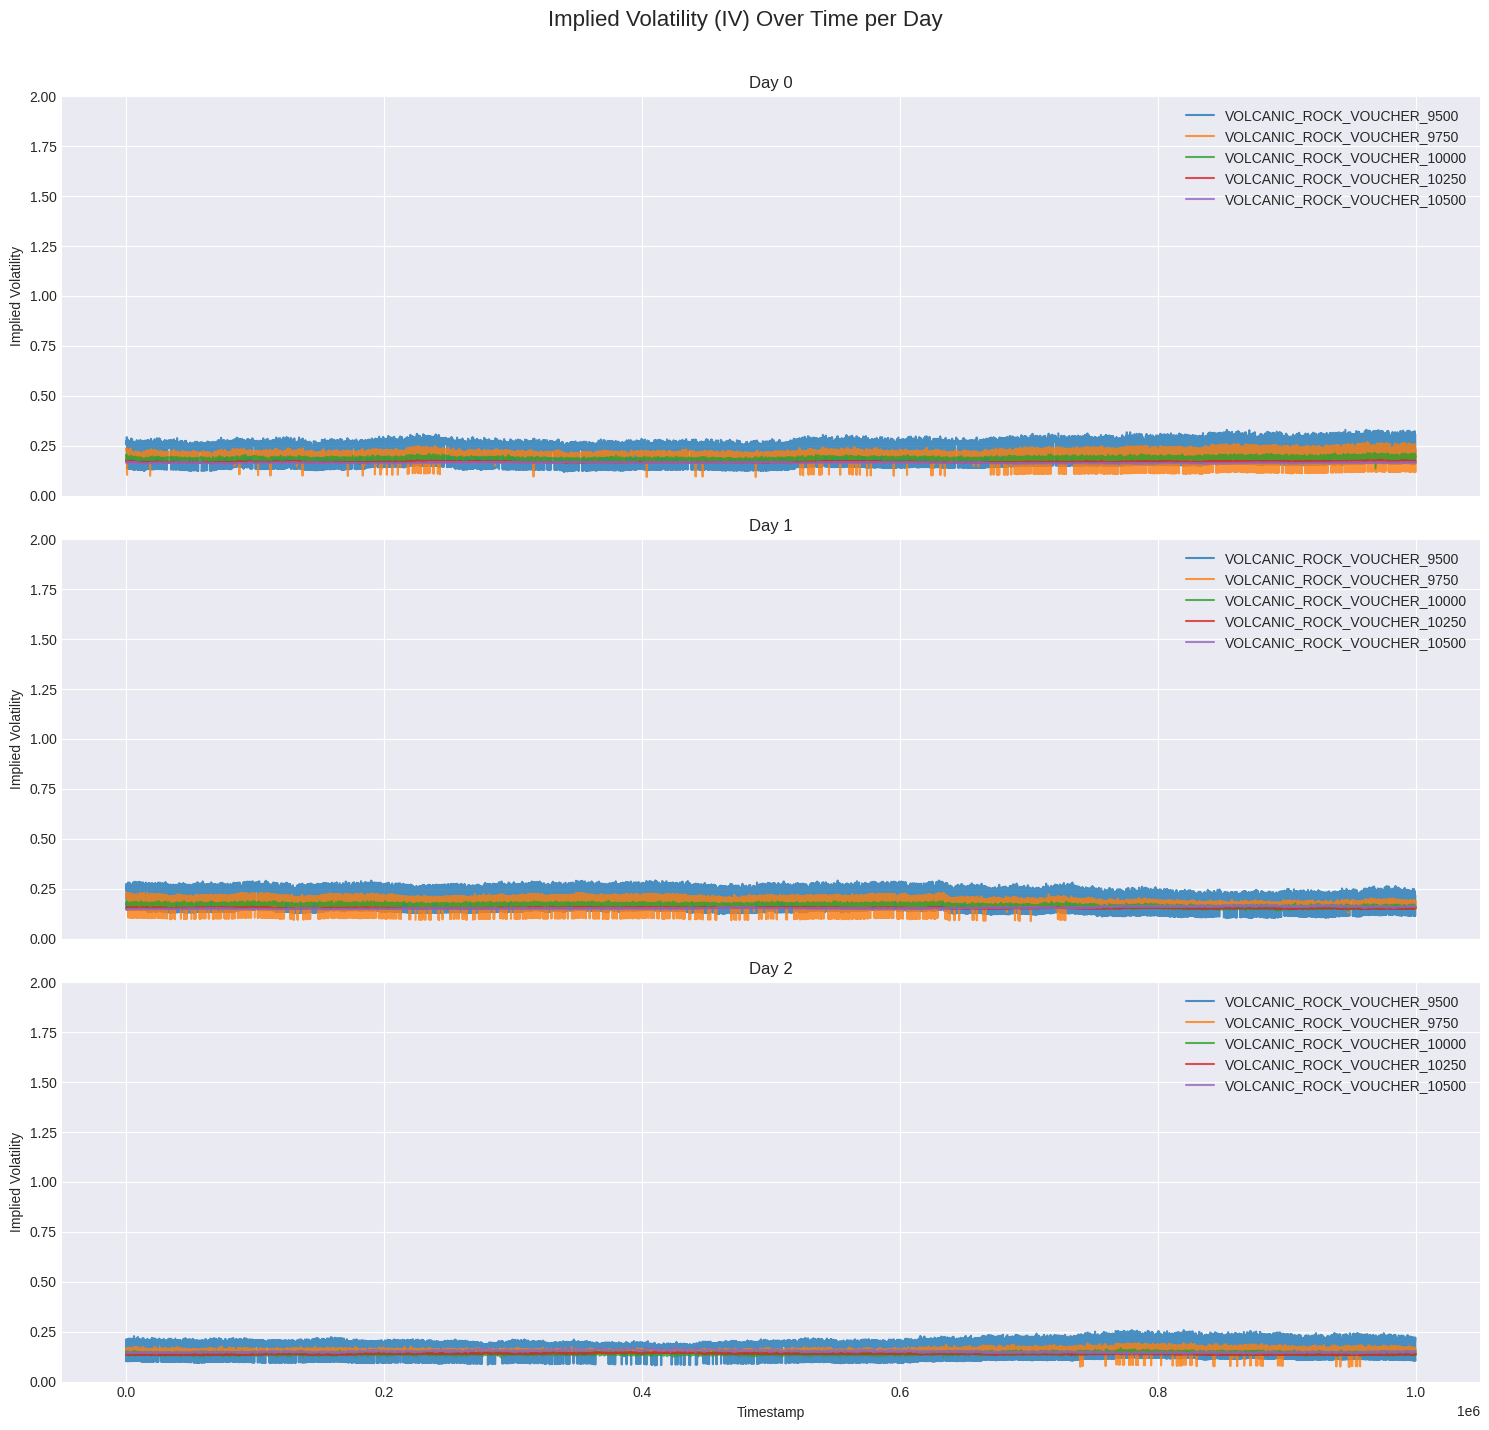

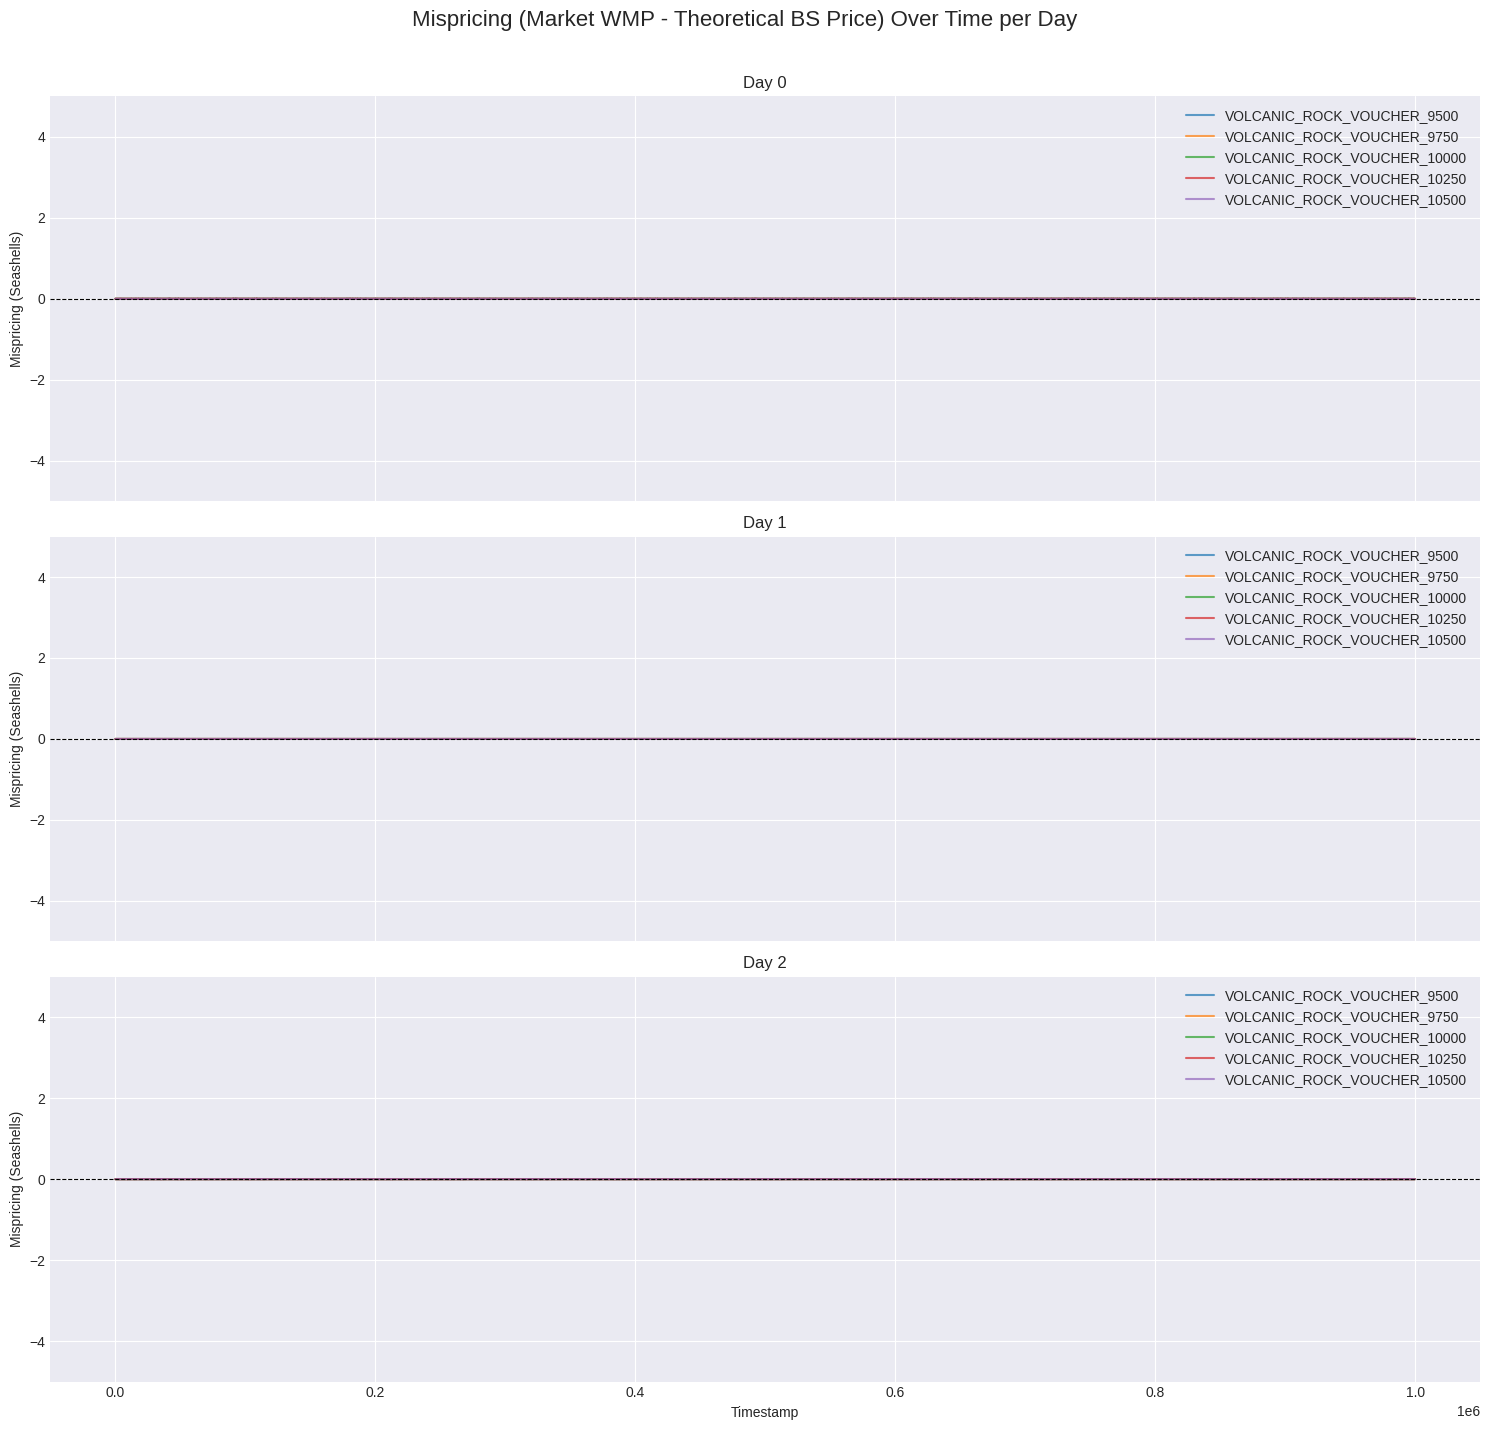

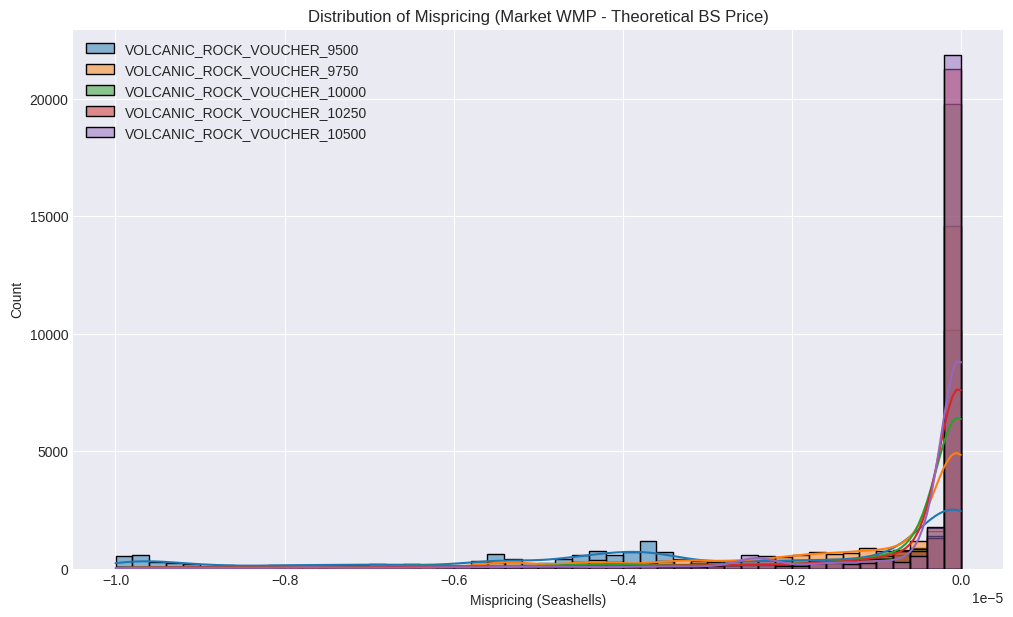

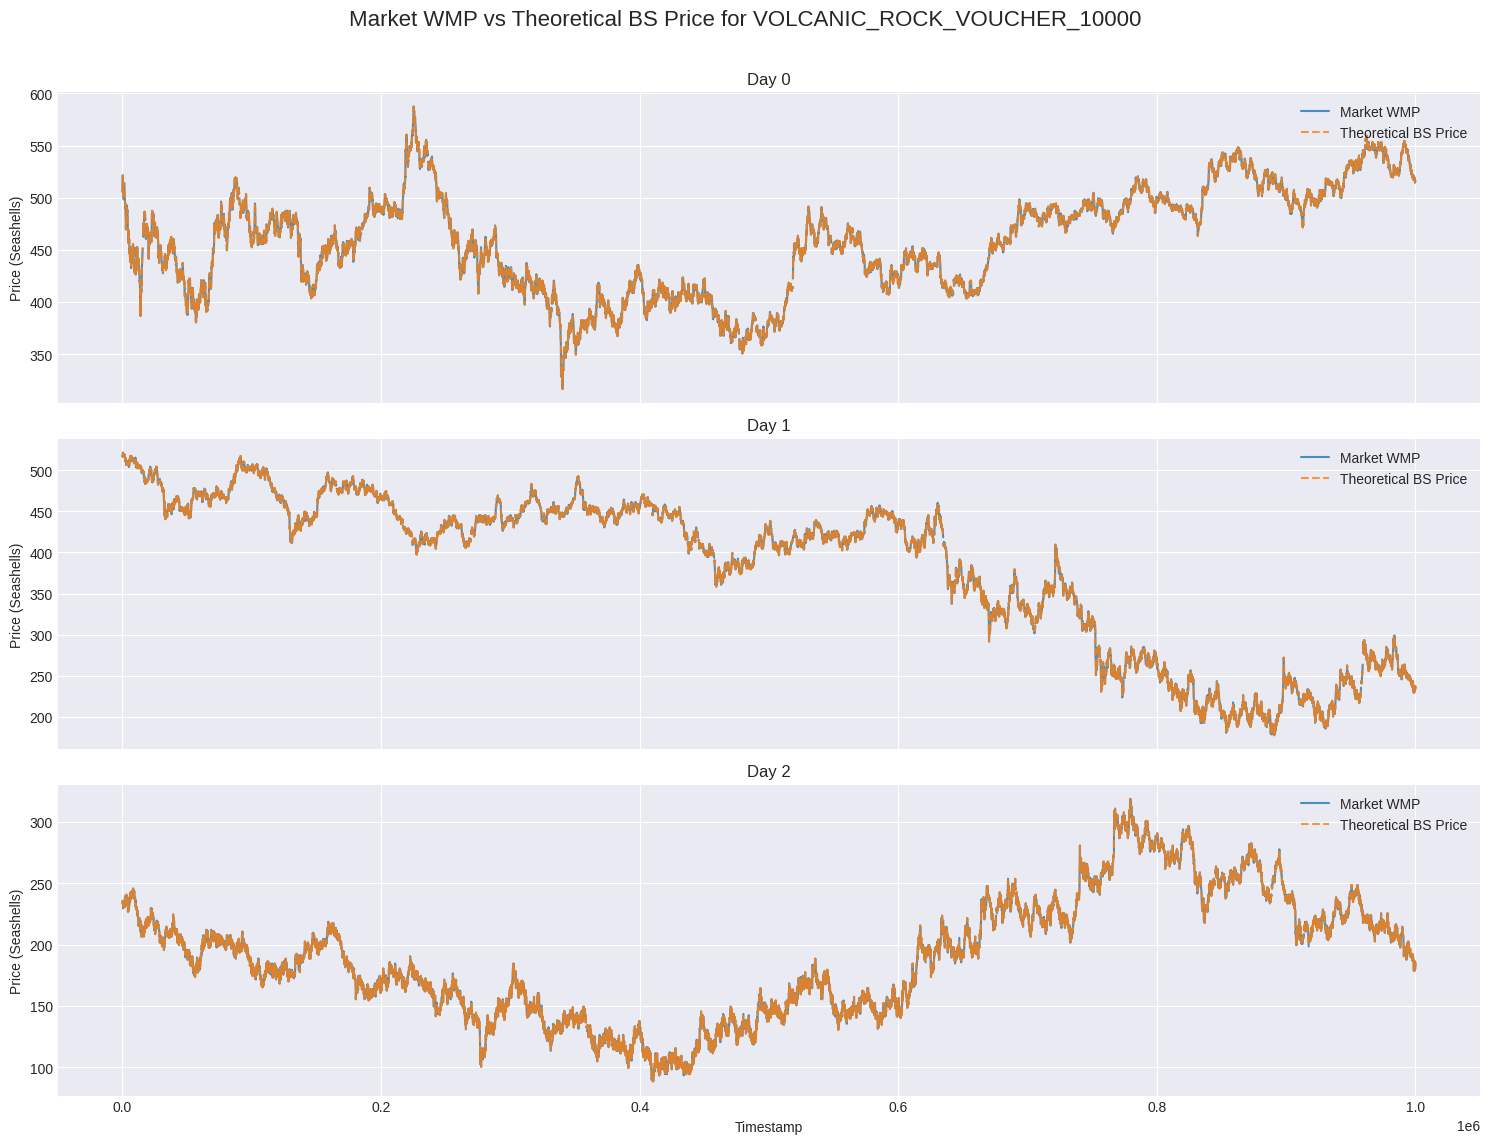


Summary Statistics for Calculated Metrics:
                  S           tte  VOLCANIC_ROCK_VOUCHER_9500_iv  \
count  30000.000000  30000.000000                   28137.000000   
mean   10332.006385      0.017857                       0.205343   
std      141.717496      0.001146                       0.058978   
min    10028.500000      0.015873                       0.080625   
25%    10199.203825      0.016865                       0.148594   
50%    10388.140032      0.017857                       0.211821   
75%    10452.500000      0.018849                       0.256813   
max    10585.500000      0.019841                       0.329123   

       VOLCANIC_ROCK_VOUCHER_9750_iv  VOLCANIC_ROCK_VOUCHER_10000_iv  \
count                   29103.000000                    29343.000000   
mean                        0.184983                        0.164105   
std                         0.031580                        0.019079   
min                         0.074099                   

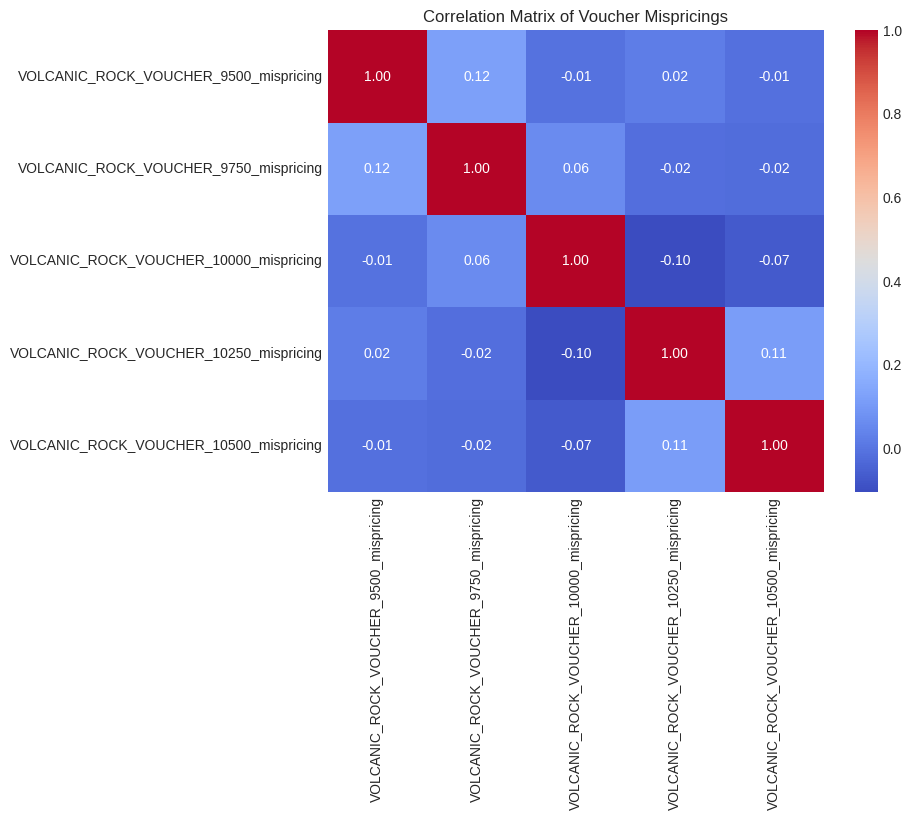

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm  # More robust than manual implementation
from google.colab import files
import io

# --- Black-Scholes & IV Helper Functions (Copied from Strategy) ---
# Constants
RISK_FREE_RATE = 0.0
TRADING_DAYS_PER_YEAR = 252.0
START_DAYS_TTE_ROUND_3 = 5.0

def norm_cdf(x):
    """Cumulative distribution function for the standard normal distribution"""
    return norm.cdf(x)

def norm_pdf(x):
    """Probability density function for the standard normal distribution"""
    return norm.pdf(x)

def black_scholes_call(S, K, T, r, sigma):
    """ Computes Black-Scholes price for a call option. """
    if sigma <= 1e-6 or T <= 1e-9 or S <= 0: # Add check for S > 0
        return max(0, S - K) # Intrinsic value

    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    price = (S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2))
    return price

def vega(S, K, T, r, sigma):
    """ Computes Vega of an option. """
    if sigma <= 1e-6 or T <= 1e-9 or S <= 0: # Add check for S > 0
        return 0.0
    # Need to handle potential domain error if S/K is non-positive
    try:
        d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    except ValueError:
        return 0.0 # Cannot calculate log(S/K)
    vega_value = S * norm_pdf(d1) * math.sqrt(T)
    return vega_value

def implied_volatility(market_price, S, K, T, r, tolerance=1e-5, max_iterations=100):
    """ Computes implied volatility using Newton-Raphson method. """
    # Add basic input validation
    if T <= 1e-9 or S <= 0 or K <= 0 or market_price <= 0:
        #print(f"IV Input Error: T={T}, S={S}, K={K}, MktP={market_price}")
        return np.nan # Indicate failure clearly

    # Lower bound check: Price must be above intrinsic value (discounted)
    min_price = max(0, S - K * math.exp(-r * T))
    if market_price < min_price * 0.99: # Allow slight tolerance
        #print(f"Price below intrinsic: MktP={market_price}, MinP={min_price}")
        return np.nan # Price below intrinsic value, IV undefined or complex

    sigma = 0.5 # Initial guess
    for i in range(max_iterations):
        try:
            price = black_scholes_call(S, K, T, r, sigma)
            v = vega(S, K, T, r, sigma)
        except ValueError: # Catch math domain errors inside BS/Vega too
             #print(f"Math Error in BS/Vega: S={S}, K={K}, T={T}, sigma={sigma}")
             return np.nan

        diff = price - market_price

        if abs(diff) < tolerance:
            return sigma
        if v < 1e-6: # Vega too small, numerical instability
             #print(f"Vega too small: {v}")
             break # Avoid division by zero

        # Newton-Raphson step with damping and bounds
        sigma_change = diff / v
        sigma = sigma - np.clip(sigma_change, -0.5, 0.5) # Damp large steps

        # Add bounds to sigma to prevent divergence
        sigma = max(1e-4, min(sigma, 5.0)) # Clamp sigma between 0.01% and 500%

    # If not converged, return NaN
    #print(f"No convergence: Last sigma={sigma}, diff={diff}")
    return np.nan


# --- Shared Helper Functions ---
def calculate_weighted_mid_price(row, product_prefix):
    """Calculates WMP from a DataFrame row for a specific product."""
    bid_price = row[f'{product_prefix}bid_price_1']
    ask_price = row[f'{product_prefix}ask_price_1']
    bid_vol = row[f'{product_prefix}bid_volume_1']
    ask_vol = row[f'{product_prefix}ask_volume_1']

    if pd.isna(bid_price) or pd.isna(ask_price):
        return np.nan # Cannot calculate if best bid/ask is missing
    if pd.isna(bid_vol) or bid_vol == 0: bid_vol = 0
    if pd.isna(ask_vol) or ask_vol == 0: ask_vol = 0

    if bid_vol + ask_vol == 0:
        return (bid_price + ask_price) / 2.0
    else:
        return (bid_price * ask_vol + ask_price * bid_vol) / (bid_vol + ask_vol)

def calculate_tte(timestamp: int) -> float:
    """ Calculates Time-To-Expiry in years for Round 3. """
    if timestamp > 1_000_000: timestamp = 1_000_000
    tte_days = START_DAYS_TTE_ROUND_3 - (timestamp / 1_000_000.0)
    tte_years = max(1e-9, tte_days / TRADING_DAYS_PER_YEAR) # Avoid T=0 exactly
    return tte_years

# --- File Upload ---
print("Please upload the 6 CSV files (prices_round_3_day_X.csv and trades_round_3_day_X.csv)")
uploaded = files.upload()

# --- Data Loading and Preparation ---
prices_dfs = []
trades_dfs = []

for day in range(3):
    prices_filename = f'prices_round_3_day_{day}.csv'
    trades_filename = f'trades_round_3_day_{day}.csv'

    if prices_filename in uploaded:
        print(f"Loading {prices_filename}...")
        try:
            df = pd.read_csv(io.BytesIO(uploaded[prices_filename]), delimiter=';')
            df['day'] = day
            prices_dfs.append(df)
            print(f"Loaded {prices_filename} shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {prices_filename}: {e}")
    else:
        print(f"File {prices_filename} not found in upload.")

    if trades_filename in uploaded:
        print(f"Loading {trades_filename}...")
        try:
            # Trades file might have simpler structure based on head provided
            df = pd.read_csv(io.BytesIO(uploaded[trades_filename]), delimiter=';')
            df['day'] = day
            trades_dfs.append(df)
            print(f"Loaded {trades_filename} shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {trades_filename}: {e}")
    else:
         print(f"File {trades_filename} not found in upload.")

if not prices_dfs:
    print("\nNo price data loaded. Cannot continue analysis.")
else:
    prices_all = pd.concat(prices_dfs, ignore_index=True)
    print(f"\nCombined Prices DataFrame shape: {prices_all.shape}")
    print("Prices columns:", prices_all.columns.tolist())

    # Filter for Volcanic Products
    volcanic_products = [
        "VOLCANIC_ROCK",
        "VOLCANIC_ROCK_VOUCHER_9500",
        "VOLCANIC_ROCK_VOUCHER_9750",
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250",
        "VOLCANIC_ROCK_VOUCHER_10500"
    ]
    prices_volcanic = prices_all[prices_all['product'].isin(volcanic_products)].copy()
    print(f"Filtered Volcanic Prices shape: {prices_volcanic.shape}")

    # --- Feature Engineering: Pivot and Calculate Metrics ---
    print("\nPivoting data...")
    # Pivot to have products as columns for easier calculation
    prices_pivot = prices_volcanic.pivot_table(
        index=['day', 'timestamp'],
        columns='product',
        values=['bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1', 'mid_price']
    )

    # Flatten MultiIndex columns (e.g., ('bid_price_1', 'VOLCANIC_ROCK') -> 'VOLCANIC_ROCK_bid_price_1')
    prices_pivot.columns = [f'{prod}_{level}' for level, prod in prices_pivot.columns]
    prices_pivot = prices_pivot.reset_index()
    print(f"Pivoted DataFrame shape: {prices_pivot.shape}")
    print("Pivoted columns:", prices_pivot.columns.tolist())


    print("\nCalculating Weighted Mid Prices (WMP)...")
    for product in volcanic_products:
        # Check if columns exist before trying calculation
        bid_col = f'{product}_bid_price_1'
        ask_col = f'{product}_ask_price_1'
        wmp_col = f'{product}_wmp'
        if bid_col in prices_pivot.columns and ask_col in prices_pivot.columns:
             prices_pivot[wmp_col] = prices_pivot.apply(lambda row: calculate_weighted_mid_price(row, f'{product}_'), axis=1)
        else:
            print(f"Warning: Price/Volume columns missing for {product}. Cannot calculate WMP.")
            prices_pivot[wmp_col] = np.nan


    print("Calculating Time-To-Expiry (TTE)...")
    prices_pivot['tte'] = prices_pivot['timestamp'].apply(calculate_tte)

    # Add Underlying Price (S) column for convenience
    prices_pivot['S'] = prices_pivot['VOLCANIC_ROCK_wmp']

    print("Calculating Implied Volatility (IV), BS Price, and Mispricing...")
    # Ensure S is filled forward to handle potential NaNs in rock WMP
    prices_pivot['S'] = prices_pivot['S'].ffill()

    iv_fail_counts = {prod: 0 for prod in volcanic_products if 'VOUCHER' in prod}
    total_rows = len(prices_pivot)

    for product in volcanic_products:
        if 'VOUCHER' not in product:
            continue

        strike = int(product.split('_')[-1])
        wmp_col = f'{product}_wmp'
        iv_col = f'{product}_iv'
        bs_col = f'{product}_bs_price'
        misprice_col = f'{product}_mispricing'
        spread_col = f'{product}_spread' # Bid-Ask Spread

        # Check necessary columns exist
        if wmp_col not in prices_pivot.columns or 'S' not in prices_pivot.columns:
             print(f"Warning: WMP or S column missing for {product}. Skipping IV/BS calc.")
             prices_pivot[iv_col] = np.nan
             prices_pivot[bs_col] = np.nan
             prices_pivot[misprice_col] = np.nan
             prices_pivot[spread_col] = np.nan
             continue

        print(f" Processing {product} (K={strike})...")

        # Calculate IV (apply row-wise, handle NaNs)
        iv_results = prices_pivot.apply(
            lambda row: implied_volatility(
                row[wmp_col], row['S'], strike, row['tte'], RISK_FREE_RATE
            ) if pd.notna(row[wmp_col]) and pd.notna(row['S']) else np.nan,
            axis=1
        )
        prices_pivot[iv_col] = iv_results
        iv_fail_counts[product] = iv_results.isna().sum()


        # Calculate BS Price using the calculated IV
        prices_pivot[bs_col] = prices_pivot.apply(
            lambda row: black_scholes_call(
                row['S'], strike, row['tte'], RISK_FREE_RATE, row[iv_col]
            ) if pd.notna(row[iv_col]) and pd.notna(row['S']) else np.nan,
            axis=1
        )

        # Calculate Mispricing (Market WMP - Theoretical BS Price)
        prices_pivot[misprice_col] = prices_pivot[wmp_col] - prices_pivot[bs_col]

        # Calculate Bid-Ask Spread
        ask_price_col = f'{product}_ask_price_1'
        bid_price_col = f'{product}_bid_price_1'
        if ask_price_col in prices_pivot.columns and bid_price_col in prices_pivot.columns:
             prices_pivot[spread_col] = prices_pivot[ask_price_col] - prices_pivot[bid_price_col]
        else:
             prices_pivot[spread_col] = np.nan


    print("\nIV Calculation Failure Report:")
    for prod, count in iv_fail_counts.items():
        print(f"  {prod}: {count} failures ({count/total_rows:.2%})")

    # --- Analysis and Visualization ---
    print("\nGenerating Plots...")

    # 1. Plot Implied Volatility Over Time (per Day)
    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
    iv_cols = [f'{p}_iv' for p in volcanic_products if 'VOUCHER' in p]
    fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    fig.suptitle('Implied Volatility (IV) Over Time per Day', fontsize=16)
    for day in range(3):
        ax = axes[day]
        daily_data = prices_pivot[prices_pivot['day'] == day]
        for col in iv_cols:
             # Only plot if column exists and has non-NaN data
            if col in daily_data.columns and daily_data[col].notna().any():
                ax.plot(daily_data['timestamp'], daily_data[col], label=col.replace('_iv',''), alpha=0.8)
        ax.set_title(f'Day {day}')
        ax.set_ylabel('Implied Volatility')
        ax.legend(loc='upper right')
        ax.set_ylim(0, 2.0) # Set reasonable IV limits (e.g., 0% to 200%)
    plt.xlabel('Timestamp')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout
    plt.show()

    # 2. Plot Mispricing Over Time (per Day)
    misprice_cols = [f'{p}_mispricing' for p in volcanic_products if 'VOUCHER' in p]
    fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    fig.suptitle('Mispricing (Market WMP - Theoretical BS Price) Over Time per Day', fontsize=16)
    max_abs_misprice = prices_pivot[misprice_cols].abs().max().max() # Find max absolute mispricing for y-lim
    ylim = max(5, max_abs_misprice * 1.1) if pd.notna(max_abs_misprice) else 5 # Set dynamic y-limit

    for day in range(3):
        ax = axes[day]
        daily_data = prices_pivot[prices_pivot['day'] == day]
        for col in misprice_cols:
             if col in daily_data.columns and daily_data[col].notna().any():
                ax.plot(daily_data['timestamp'], daily_data[col], label=col.replace('_mispricing',''), alpha=0.7)
        ax.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
        ax.set_title(f'Day {day}')
        ax.set_ylabel('Mispricing (Seashells)')
        ax.legend(loc='upper right')
        ax.set_ylim(-ylim, ylim) # Symmetrical ylim based on data
    plt.xlabel('Timestamp')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # 3. Plot Mispricing Distribution
    plt.figure(figsize=(12, 7))
    for col in misprice_cols:
         if col in prices_pivot.columns and prices_pivot[col].notna().any():
            sns.histplot(prices_pivot[col].dropna(), kde=True, label=col.replace('_mispricing',''), bins=50)
    plt.title('Distribution of Mispricing (Market WMP - Theoretical BS Price)')
    plt.xlabel('Mispricing (Seashells)')
    plt.legend()
    plt.show()

    # 4. Plot Market WMP vs Theoretical BS Price for one voucher (e.g., 10000)
    voucher_to_plot = 'VOLCANIC_ROCK_VOUCHER_10000'
    wmp_col = f'{voucher_to_plot}_wmp'
    bs_col = f'{voucher_to_plot}_bs_price'

    if wmp_col in prices_pivot.columns and bs_col in prices_pivot.columns:
        fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        fig.suptitle(f'Market WMP vs Theoretical BS Price for {voucher_to_plot}', fontsize=16)
        for day in range(3):
            ax = axes[day]
            daily_data = prices_pivot[prices_pivot['day'] == day]
            if daily_data[wmp_col].notna().any():
                 ax.plot(daily_data['timestamp'], daily_data[wmp_col], label='Market WMP', alpha=0.8)
            if daily_data[bs_col].notna().any():
                 ax.plot(daily_data['timestamp'], daily_data[bs_col], label='Theoretical BS Price', linestyle='--', alpha=0.8)
            ax.set_title(f'Day {day}')
            ax.set_ylabel('Price (Seashells)')
            ax.legend(loc='upper right')
        plt.xlabel('Timestamp')
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
    else:
        print(f"Columns for {voucher_to_plot} not found for WMP vs BS plot.")


    # --- Summary Statistics ---
    print("\nSummary Statistics for Calculated Metrics:")
    stats_cols = ['S', 'tte'] + iv_cols + misprice_cols + [f'{p}_spread' for p in volcanic_products if 'VOUCHER' in p]
    # Filter out columns that don't actually exist in the pivot table
    stats_cols = [col for col in stats_cols if col in prices_pivot.columns]
    print(prices_pivot[stats_cols].describe())

    print("\nCorrelation of Mispricings:")
    misprice_data = prices_pivot[misprice_cols].dropna()
    if not misprice_data.empty:
        corr_matrix = misprice_data.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Voucher Mispricings')
        plt.show()
    else:
        print("Not enough non-NaN mispricing data for correlation matrix.")

Loading prices_round_3_day_0.csv...
Loading prices_round_3_day_1.csv...
Loading prices_round_3_day_2.csv...

Pivoting data...
Calculating WMP, TTE, Smoothed S...
Calculating Implied Volatility (IV) for all vouchers...
Calculating Smoothed IV (Average of valid IVs)...
Calculating Theoretical BS Fair Value...

--- Running PnL Simulation for Different Parameters ---
Simulating: Tight_LowAlpha
  Finished Tight_LowAlpha. Total PnL: -144,410
Simulating: Medium_Balanced
  Finished Medium_Balanced. Total PnL: -1,081,990
Simulating: Wide_HighAlpha
  Finished Wide_HighAlpha. Total PnL: -1,798,646
Simulating: Aggressive_MM
  Finished Aggressive_MM. Total PnL: -13,965,623

--- Simulation Results ---
Parameter Set: Tight_LowAlpha
  Total PnL: -144,409.85
  PnL Breakdown:
    VOLCANIC_ROCK: 0.00
    VOLCANIC_ROCK_VOUCHER_9500: -31,438.49
    VOLCANIC_ROCK_VOUCHER_9750: -32,246.24
    VOLCANIC_ROCK_VOUCHER_10000: -27,431.86
    VOLCANIC_ROCK_VOUCHER_10250: -23,977.37
    VOLCANIC_ROCK_VOUCHER_10500: 

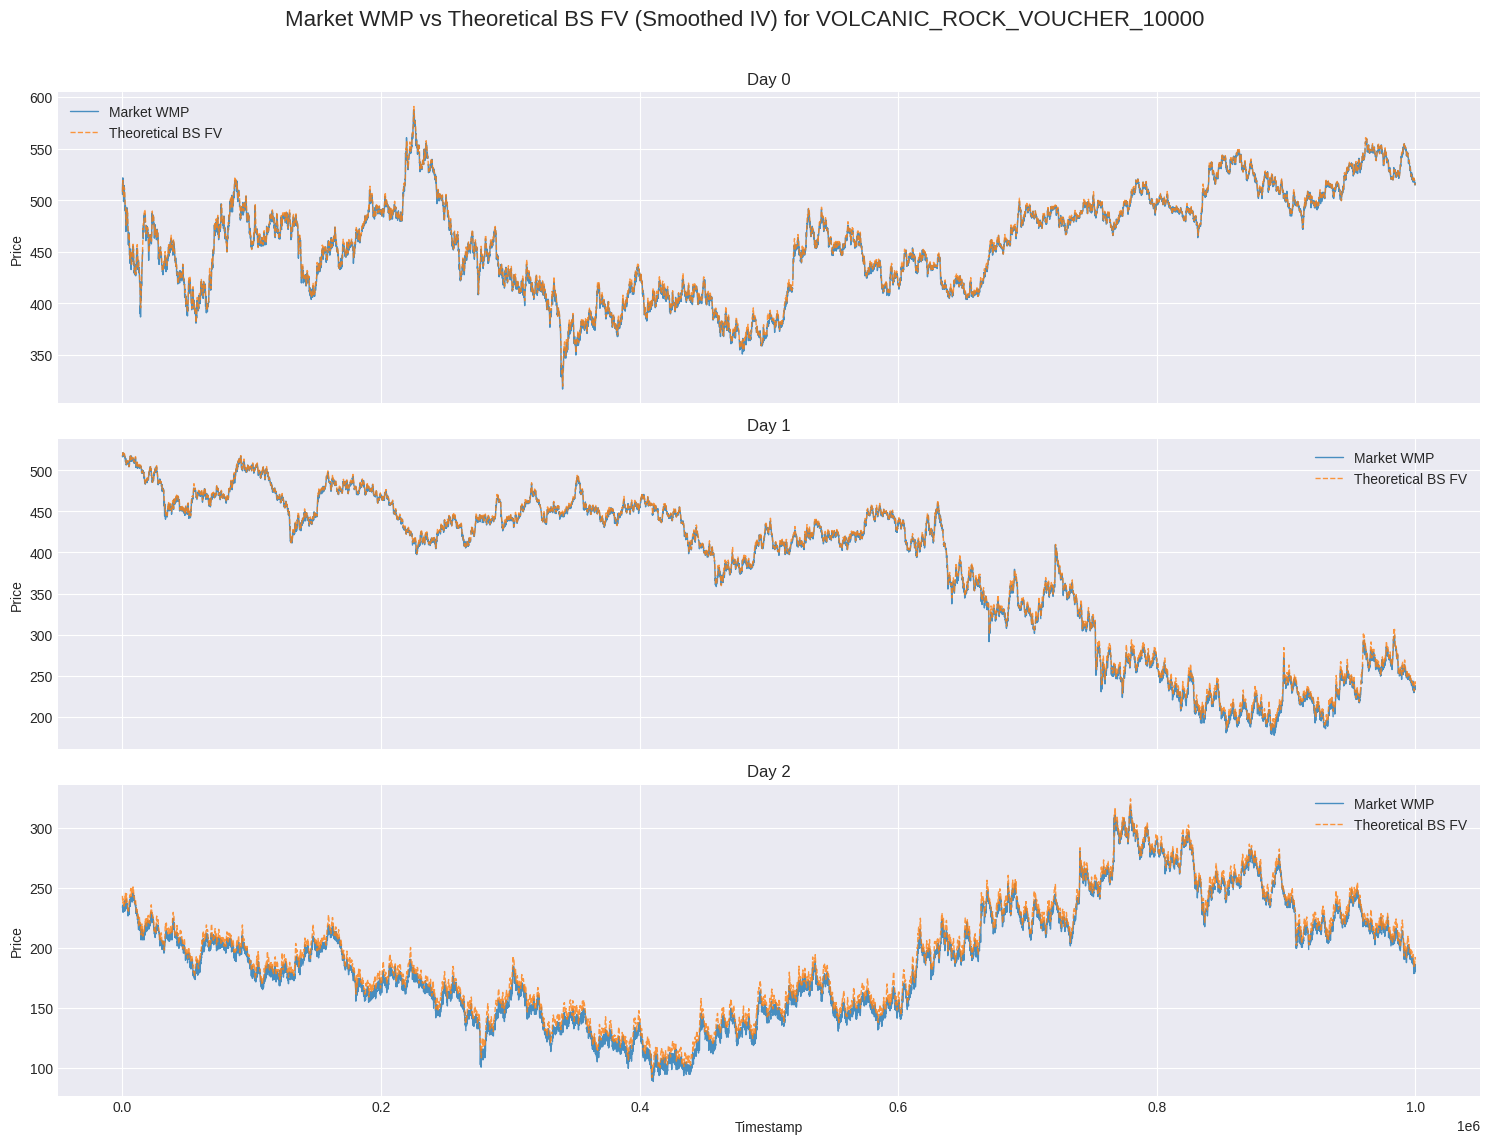


Analyzing Spread Distribution for Best Parameter Set: Tight_LowAlpha


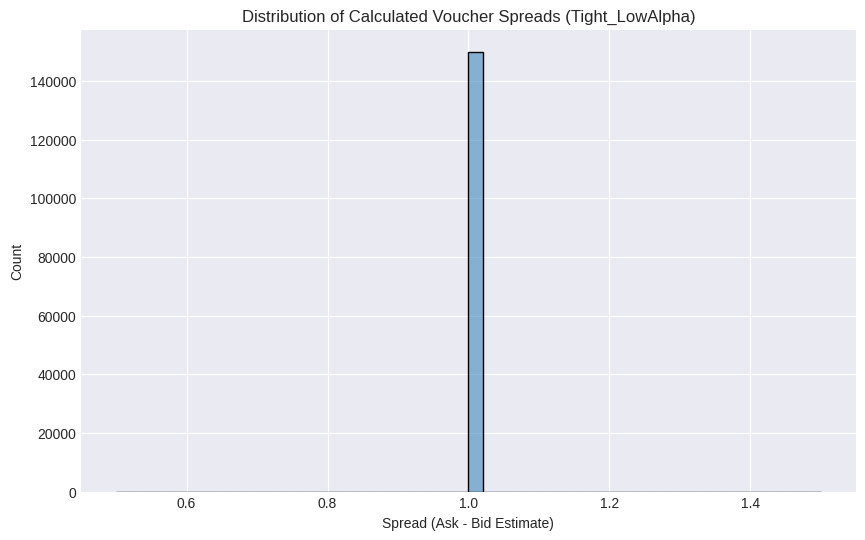

Spread Stats: Mean=1.00, Median=1.00, Min=1.00, Max=1.00


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from collections import deque
from google.colab import files
import io
import json # For potential future use

# --- Black-Scholes & IV Helper Functions (Use refined versions) ---
RISK_FREE_RATE = 0.0
TRADING_DAYS_PER_YEAR = 252.0
START_DAYS_TTE_ROUND_3 = 5.0

def norm_cdf(x): return norm.cdf(x)
def norm_pdf(x): return norm.pdf(x)

def black_scholes_call(S, K, T, r, sigma):
    if sigma <= 1e-6 or T <= 1e-9 or S <= 0: return max(0, S - K)
    if K <= 0: return max(0, S)
    if S / K <= 0: return max(0, S - K)
    try:
        d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
        price = (S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2))
    except (ValueError, OverflowError):
        return max(0, S - K) # Fallback to intrinsic on math error
    return price

def vega(S, K, T, r, sigma):
    if sigma <= 1e-6 or T <= 1e-9 or S <= 0 or K <= 0: return 0.0
    if S / K <= 0: return 0.0
    try:
        d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    except (ValueError, OverflowError): return 0.0
    return S * norm_pdf(d1) * math.sqrt(T)

def implied_volatility(market_price, S, K, T, r, tolerance=1e-4, max_iterations=50): # Relaxed tolerance slightly
    if T <= 1e-9 or S <= 0 or K <= 0 or market_price <= 0: return np.nan
    min_price = max(0, S - K * math.exp(-r * T))
    # Allow price to be slightly below intrinsic before failing IV calc
    if market_price < min_price - 0.1: return np.nan # Check against min price

    sigma = 0.3 # Initial guess (adjust based on previous IV plots)
    for i in range(max_iterations):
        try:
            price = black_scholes_call(S, K, T, r, sigma)
            v = vega(S, K, T, r, sigma)
        except (ValueError, OverflowError): return np.nan

        diff = price - market_price
        if abs(diff) < tolerance: return sigma
        if v < 1e-6: break

        sigma_change = diff / v
        # Limit step size more aggressively
        sigma = sigma - np.clip(sigma_change, -0.1, 0.1)
        sigma = max(1e-3, min(sigma, 3.0)) # Bounds 0.1% to 300%

    # Check final diff after loop
    if abs(diff) >= tolerance * 5: # If still far off, consider it failed
        return np.nan
    return sigma # Return best guess if close enough or vega died

# --- Shared Helper Functions ---
def calculate_weighted_mid_price(row, product_prefix):
    bid_price = row[f'{product_prefix}bid_price_1']
    ask_price = row[f'{product_prefix}ask_price_1']
    bid_vol = row[f'{product_prefix}bid_volume_1']
    ask_vol = row[f'{product_prefix}ask_volume_1']
    if pd.isna(bid_price) or pd.isna(ask_price): return np.nan
    if pd.isna(bid_vol) or bid_vol == 0: bid_vol = 0
    if pd.isna(ask_vol) or ask_vol == 0: ask_vol = 0
    if bid_vol + ask_vol == 0: return (bid_price + ask_price) / 2.0
    return (bid_price * ask_vol + ask_price * bid_vol) / (bid_vol + ask_vol)

def calculate_tte(timestamp: int) -> float:
    if timestamp > 1_000_000: timestamp = 1_000_000
    tte_days = START_DAYS_TTE_ROUND_3 - (timestamp / 1_000_000.0)
    tte_years = max(1e-9, tte_days / TRADING_DAYS_PER_YEAR)
    return tte_years



# --- Data Loading and Preparation ---
prices_dfs = []
for day in range(3):
    prices_filename = f'prices_round_3_day_{day}.csv'
    if prices_filename in uploaded:
        print(f"Loading {prices_filename}...")
        try:
            df = pd.read_csv(io.BytesIO(uploaded[prices_filename]), delimiter=';')
            df['day'] = day
            prices_dfs.append(df)
        except Exception as e: print(f"Error loading {prices_filename}: {e}")
    else: print(f"File {prices_filename} not found.")

if not prices_dfs:
    print("\nNo price data loaded. Cannot continue analysis.")
else:
    prices_all = pd.concat(prices_dfs, ignore_index=True)
    volcanic_products = ["VOLCANIC_ROCK"] + [f"VOLCANIC_ROCK_VOUCHER_{k}" for k in [9500, 9750, 10000, 10250, 10500]]
    prices_volcanic = prices_all[prices_all['product'].isin(volcanic_products)].copy()

    print("\nPivoting data...")
    prices_pivot = prices_volcanic.pivot_table(
        index=['day', 'timestamp'], columns='product',
        values=['bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1', 'mid_price']
    )
    prices_pivot.columns = [f'{prod}_{level}' for level, prod in prices_pivot.columns]
    prices_pivot = prices_pivot.reset_index()

    print("Calculating WMP, TTE, Smoothed S...")
    # Calculate WMP for all products first
    for product in volcanic_products:
        bid_col, ask_col, wmp_col = f'{product}_bid_price_1', f'{product}_ask_price_1', f'{product}_wmp'
        if bid_col in prices_pivot.columns and ask_col in prices_pivot.columns:
             prices_pivot[wmp_col] = prices_pivot.apply(lambda row: calculate_weighted_mid_price(row, f'{product}_'), axis=1)
        else: prices_pivot[wmp_col] = np.nan

    # Calculate TTE
    prices_pivot['tte'] = prices_pivot['timestamp'].apply(calculate_tte)

    # Calculate Smoothed S (Moving Average of Rock WMP)
    rock_wmp_col = 'VOLCANIC_ROCK_wmp'
    smooth_window_s = 5 # Parameter for smoothing S
    if rock_wmp_col in prices_pivot.columns:
        prices_pivot['S'] = prices_pivot[rock_wmp_col].rolling(window=smooth_window_s, min_periods=1).mean()
        prices_pivot['S'] = prices_pivot['S'].ffill() # Fill initial NaNs
    else:
        print("Error: VOLCANIC_ROCK WMP column not found. Cannot calculate S.")
        prices_pivot['S'] = np.nan # Ensure column exists even if calc fails

    print("Calculating Implied Volatility (IV) for all vouchers...")
    iv_data = {}
    for product in volcanic_products:
        if 'VOUCHER' not in product: continue
        strike = int(product.split('_')[-1])
        wmp_col, iv_col = f'{product}_wmp', f'{product}_iv'
        if wmp_col not in prices_pivot.columns or 'S' not in prices_pivot.columns: continue

        iv_results = prices_pivot.apply(
            lambda row: implied_volatility(row[wmp_col], row['S'], strike, row['tte'], RISK_FREE_RATE)
            if pd.notna(row[wmp_col]) and pd.notna(row['S']) else np.nan, axis=1
        )
        prices_pivot[iv_col] = iv_results
        iv_data[product] = iv_results # Store IV series

    print("Calculating Smoothed IV (Average of valid IVs)...")
    iv_cols_only = [f'{p}_iv' for p in volcanic_products if 'VOUCHER' in p and f'{p}_iv' in prices_pivot.columns]
    if iv_cols_only:
         # Calculate row-wise mean IV, ignoring NaNs
         prices_pivot['smoothed_iv'] = prices_pivot[iv_cols_only].mean(axis=1)
         # Apply EMA smoothing to the row-wise average IV for stability
         iv_ema_alpha = 0.2 # Parameter for smoothing the smoothed IV
         prices_pivot['smoothed_iv_ema'] = prices_pivot['smoothed_iv'].ewm(alpha=iv_ema_alpha, adjust=False).mean()
         prices_pivot['smoothed_iv_ema'] = prices_pivot['smoothed_iv_ema'].ffill() # Fill initial NaNs
    else:
        print("Warning: No IV columns found to calculate smoothed IV.")
        prices_pivot['smoothed_iv_ema'] = 0.2 # Assign a default if none calculated

    print("Calculating Theoretical BS Fair Value...")
    for product in volcanic_products:
        if 'VOUCHER' not in product: continue
        strike = int(product.split('_')[-1])
        bs_col = f'{product}_bs_fv'
        if 'S' in prices_pivot.columns and 'smoothed_iv_ema' in prices_pivot.columns:
             prices_pivot[bs_col] = prices_pivot.apply(
                 lambda row: black_scholes_call(row['S'], strike, row['tte'], RISK_FREE_RATE, row['smoothed_iv_ema'])
                 if pd.notna(row['S']) and pd.notna(row['smoothed_iv_ema']) else np.nan, axis=1
             )
        else: prices_pivot[bs_col] = np.nan

    # --- Simulation Setup ---
    print("\n--- Running PnL Simulation for Different Parameters ---")

    # Define Parameter Sets to Test (Manually Chosen)
    # Format: {'name': {'rock_alpha': ..., 'rock_k': ..., 'rock_size': ...,
    #                   'voucher_alpha': ..., 'voucher_k': ..., 'voucher_size': ...}}
    param_sets = {
        "Tight_LowAlpha": {
            "rock_alpha": 0.02, "rock_k": 0.3, "rock_size": 50, "voucher_alpha": 0.05, "voucher_k": 0.5, "voucher_size": 60, "voucher_base_spread": 1, "voucher_iv_mult": 1.0
        },
        "Medium_Balanced": {
            "rock_alpha": 0.03, "rock_k": 0.5, "rock_size": 40, "voucher_alpha": 0.07, "voucher_k": 0.7, "voucher_size": 50, "voucher_base_spread": 1, "voucher_iv_mult": 1.2
        },
        "Wide_HighAlpha": {
            "rock_alpha": 0.05, "rock_k": 0.8, "rock_size": 30, "voucher_alpha": 0.10, "voucher_k": 1.0, "voucher_size": 40, "voucher_base_spread": 2, "voucher_iv_mult": 1.5
        },
         "Aggressive_MM": { # Try larger size, tighter k but higher alpha
            "rock_alpha": 0.04, "rock_k": 0.4, "rock_size": 60, "voucher_alpha": 0.10, "voucher_k": 0.6, "voucher_size": 70, "voucher_base_spread": 1, "voucher_iv_mult": 1.1
        },
    }

    results = {}
    limits = {"VOLCANIC_ROCK": 400}
    for p in volcanic_products:
        if "VOUCHER" in p: limits[p] = 200

    # Shift WMP column for fill simulation
    for p in volcanic_products:
        if f'{p}_wmp' in prices_pivot.columns:
            prices_pivot[f'{p}_wmp_next'] = prices_pivot.groupby('day')[f'{p}_wmp'].shift(-1)

    for name, params in param_sets.items():
        print(f"Simulating: {name}")
        total_pnl = 0
        positions = {p: 0 for p in volcanic_products}
        pnl_per_product = {p: 0 for p in volcanic_products}

        # Iterate through data (can be slow, consider sampling later)
        # Using iterrows is slow but easier for complex logic per row
        for index, row in prices_pivot.iterrows():
            if pd.isna(row['S']): continue # Need underlying price

            # Simulate Rock MM
            prod = "VOLCANIC_ROCK"
            limit = limits[prod]
            rock_fv = row['S'] # Use smoothed S as FV center
            rock_vol = 0.1 # Placeholder - real strategy calculates volatility
            position = positions[prod]
            adj_fv = rock_fv - params['rock_alpha'] * position
            dyn_spread = params['rock_k'] * rock_vol * rock_fv # Approximate spread calc
            half_spread = math.ceil(max(1, dyn_spread) / 2.0) # Base spread of 1 assumed
            bid_quote = int(math.floor(adj_fv - half_spread))
            ask_quote = int(math.ceil(adj_fv + half_spread))
            if bid_quote >= ask_quote: bid_quote = ask_quote - 1

            # Simulate Rock Fills
            wmp_next = row[f'{prod}_wmp_next']
            if pd.notna(wmp_next):
                 # Buy fill check
                 if wmp_next <= bid_quote and positions[prod] < limit:
                      fill_qty = min(params['rock_size'], limit - positions[prod])
                      pnl = fill_qty * (rock_fv - bid_quote) # PnL vs FV at time of quote
                      pnl_per_product[prod] += pnl
                      total_pnl += pnl
                      positions[prod] += fill_qty
                 # Sell fill check
                 elif wmp_next >= ask_quote and positions[prod] > -limit:
                      fill_qty = min(params['rock_size'], limit + positions[prod])
                      pnl = fill_qty * (ask_quote - rock_fv) # PnL vs FV at time of quote
                      pnl_per_product[prod] += pnl
                      total_pnl += pnl
                      positions[prod] -= fill_qty


            # Simulate Voucher MM
            smoothed_iv_ema = row['smoothed_iv_ema']
            if pd.isna(smoothed_iv_ema): continue # Need smoothed IV

            for prod in volcanic_products:
                if 'VOUCHER' not in prod: continue
                limit = limits[prod]
                bs_fv_col = f'{prod}_bs_fv'
                if pd.isna(row[bs_fv_col]): continue # Need BS FV

                theo_fv = row[bs_fv_col]
                position = positions[prod]
                adj_fv = theo_fv - params['voucher_alpha'] * position

                iv_mult = 1.0 + smoothed_iv_ema # Simple IV scaling for spread
                dyn_spread = params['voucher_k'] * params['voucher_iv_mult'] * iv_mult
                half_spread = math.ceil(max(params['voucher_base_spread'], dyn_spread) / 2.0)

                bid_quote = int(math.floor(adj_fv - half_spread))
                ask_quote = int(math.ceil(adj_fv + half_spread))
                if bid_quote <= 0: bid_quote = 1
                if ask_quote <= bid_quote: ask_quote = bid_quote + 1


                # Simulate Voucher Fills
                wmp_next = row[f'{prod}_wmp_next']
                if pd.notna(wmp_next):
                    # Buy fill check
                    if wmp_next <= bid_quote and positions[prod] < limit:
                        fill_qty = min(params['voucher_size'], limit - positions[prod])
                        pnl = fill_qty * (theo_fv - bid_quote) # PnL vs Theoretical FV
                        pnl_per_product[prod] += pnl
                        total_pnl += pnl
                        positions[prod] += fill_qty
                    # Sell fill check
                    elif wmp_next >= ask_quote and positions[prod] > -limit:
                        fill_qty = min(params['voucher_size'], limit + positions[prod])
                        pnl = fill_qty * (ask_quote - theo_fv) # PnL vs Theoretical FV
                        pnl_per_product[prod] += pnl
                        total_pnl += pnl
                        positions[prod] -= fill_qty

        results[name] = {'total_pnl': total_pnl, 'pnl_by_product': pnl_per_product}
        print(f"  Finished {name}. Total PnL: {total_pnl:,.0f}")
        #print(f"    PnL by Product: {pnl_per_product}")


    print("\n--- Simulation Results ---")
    sorted_results = sorted(results.items(), key=lambda item: item[1]['total_pnl'], reverse=True)
    for name, res in sorted_results:
        print(f"Parameter Set: {name}")
        print(f"  Total PnL: {res['total_pnl']:,.2f}")
        print("  PnL Breakdown:")
        for prod, pnl_val in res['pnl_by_product'].items():
             print(f"    {prod}: {pnl_val:,.2f}")
        print("-" * 20)

    print("\n--- Further Analysis Plots ---")
    # Plot Theoretical FV vs Market WMP for a voucher again
    voucher_to_plot = 'VOLCANIC_ROCK_VOUCHER_10000'
    wmp_col = f'{voucher_to_plot}_wmp'
    bs_col = f'{voucher_to_plot}_bs_fv' # Using the new BS FV column

    if wmp_col in prices_pivot.columns and bs_col in prices_pivot.columns:
        fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        fig.suptitle(f'Market WMP vs Theoretical BS FV (Smoothed IV) for {voucher_to_plot}', fontsize=16)
        for day in range(3):
            ax = axes[day]; daily_data = prices_pivot[prices_pivot['day'] == day]
            if daily_data[wmp_col].notna().any(): ax.plot(daily_data['timestamp'], daily_data[wmp_col], label='Market WMP', alpha=0.8, linewidth=1)
            if daily_data[bs_col].notna().any(): ax.plot(daily_data['timestamp'], daily_data[bs_col], label='Theoretical BS FV', linestyle='--', alpha=0.8, linewidth=1)
            ax.set_title(f'Day {day}'); ax.set_ylabel('Price'); ax.legend()
        plt.xlabel('Timestamp'); plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()
    else: print(f"Columns for {voucher_to_plot} not found for WMP vs BS FV plot.")

    # Plot Distribution of calculated voucher spreads for a parameter set (e.g., the best one)
    if sorted_results:
        best_param_name = sorted_results[0][0]
        best_params = param_sets[best_param_name]
        print(f"\nAnalyzing Spread Distribution for Best Parameter Set: {best_param_name}")

        spreads = []
        for index, row in prices_pivot.iterrows():
            if pd.isna(row['smoothed_iv_ema']): continue
            for prod in volcanic_products:
                if 'VOUCHER' not in prod: continue
                if pd.isna(row[f'{prod}_bs_fv']): continue

                iv_mult = 1.0 + row['smoothed_iv_ema']
                dyn_spread = best_params['voucher_k'] * best_params['voucher_iv_mult'] * iv_mult
                total_spread = max(best_params['voucher_base_spread'], dyn_spread)
                # Store the calculated spread (ask-bid) for analysis
                # half_spread = math.ceil(total_spread / 2.0) * 2 # Effective spread is often 2*ceil(half)
                spreads.append(total_spread)

        if spreads:
             plt.figure(figsize=(10, 6))
             sns.histplot(spreads, bins=50, kde=True)
             plt.title(f'Distribution of Calculated Voucher Spreads ({best_param_name})')
             plt.xlabel('Spread (Ask - Bid Estimate)')
             plt.show()
             print(f"Spread Stats: Mean={np.mean(spreads):.2f}, Median={np.median(spreads):.2f}, Min={np.min(spreads):.2f}, Max={np.max(spreads):.2f}")
        else:
            print("Could not calculate spreads for analysis.")

Loading prices_round_3_day_0.csv...
Loaded and cleaned prices_round_3_day_0.csv shape: (138904, 17)
Loading prices_round_3_day_1.csv...
Loaded and cleaned prices_round_3_day_1.csv shape: (138957, 17)
Loading prices_round_3_day_2.csv...
Loaded and cleaned prices_round_3_day_2.csv shape: (138876, 17)

Pivoting data...
Pivoted DataFrame shape: (30000, 26)
Pivoted columns sample: ['day', 'timestamp', 'VOLCANIC_ROCK_ask_price_1', 'VOLCANIC_ROCK_VOUCHER_10000_ask_price_1', 'VOLCANIC_ROCK_VOUCHER_10250_ask_price_1', 'VOLCANIC_ROCK_VOUCHER_10500_ask_price_1', 'VOLCANIC_ROCK_VOUCHER_9500_ask_price_1', 'VOLCANIC_ROCK_VOUCHER_9750_ask_price_1', 'VOLCANIC_ROCK_ask_volume_1', 'VOLCANIC_ROCK_VOUCHER_10000_ask_volume_1']

Calculating WMP for all products...
WMP columns created for 6 products.
Dropped 0 rows due to missing VOLCANIC_ROCK_wmp.
Shape after Rock WMP drop: (30000, 32)
Calculating TTE and Smoothed S...
Dropped 0 rows due to missing Smoothed S (should be 0).
Shape after S calculation: (30000

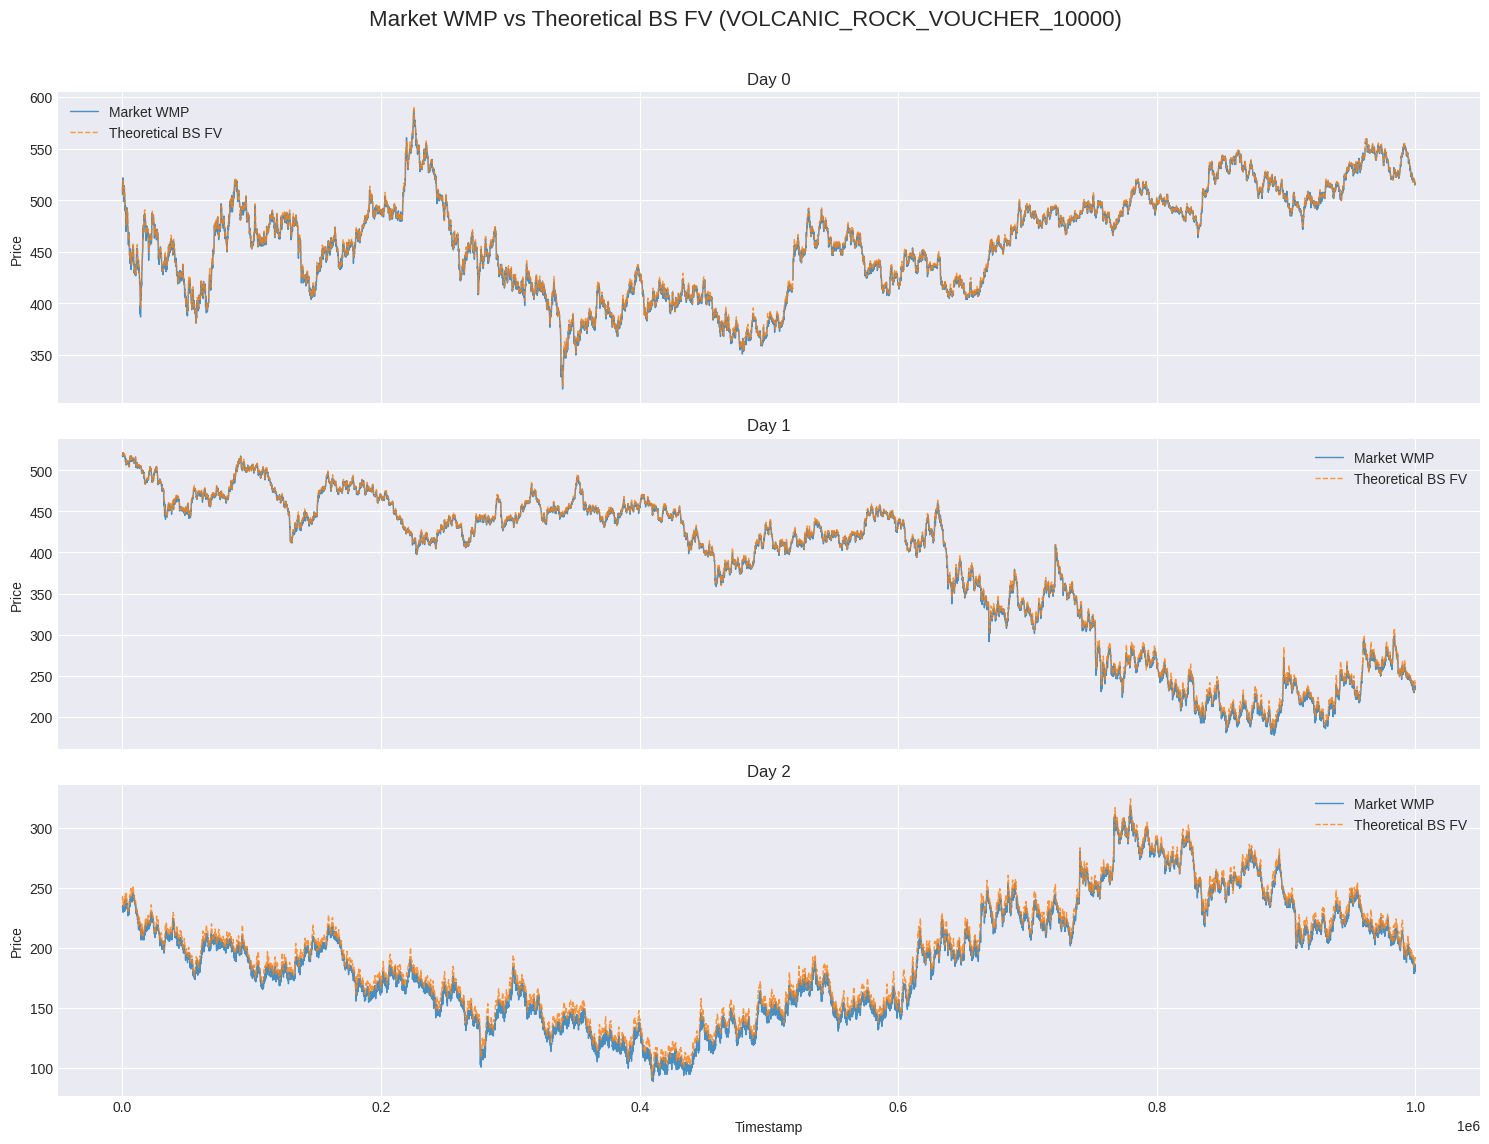


Analyzing Spread Distribution for Best Parameter Set: TighterFV_Base2


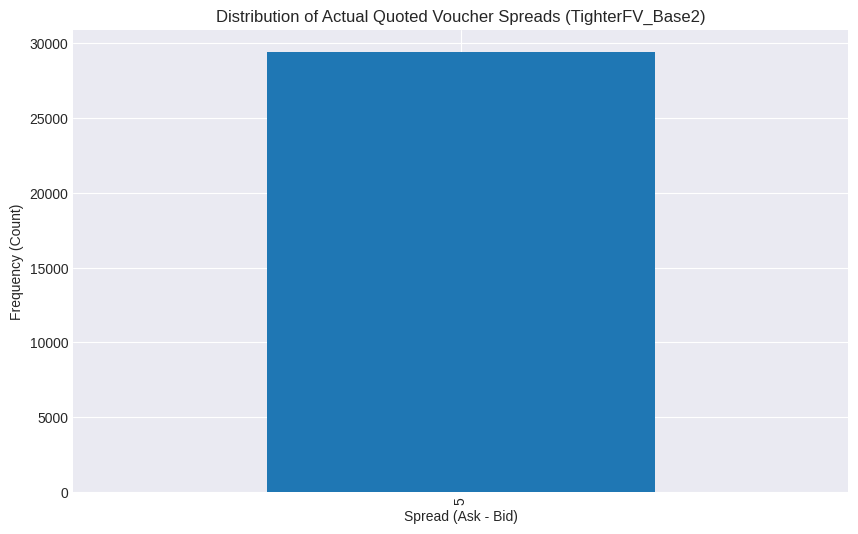

Actual Spread Stats: Mean=5.00, Median=5.00, Min=5.00, Max=5.00
Spread Counts:
5    29438
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from collections import deque
# from google.colab import files # Assuming files are already uploaded
import io
import json
import os

# --- Black-Scholes & IV Helper Functions (Keep refined versions) ---
RISK_FREE_RATE = 0.0
TRADING_DAYS_PER_YEAR = 252.0
START_DAYS_TTE_ROUND_3 = 5.0

def norm_cdf(x): return norm.cdf(x)
def norm_pdf(x): return norm.pdf(x)

def black_scholes_call(S, K, T, r, sigma):
    # Increased robustness for edge cases and potential overflows
    if sigma <= 1e-6 or T <= 1e-9 or S <= 0: return max(0, S - K)
    if K <= 0: return max(0, S)
    # Check for potential division by zero or log(0)
    if S <=0 or K<= 0: return max(0,S-K)
    # Check for S/K before log
    s_k_ratio = S / K
    if s_k_ratio <= 0: return max(0, S - K)

    try:
        term1 = (r + 0.5 * sigma**2) * T
        if term1 > 700: return max(0, S - K) # Avoid exp() overflow

        sqrtT = math.sqrt(T)
        sigma_sqrtT = sigma * sqrtT
        if sigma_sqrtT == 0: return max(0, S - K) # Avoid division by zero

        d1 = (math.log(s_k_ratio) + term1) / sigma_sqrtT # Use ratio here

        if abs(d1) > 10: return S if d1 > 0 else max(0, S-K)

        d2 = d1 - sigma_sqrtT
        # Check d2 as well for extreme values leading to precision loss
        if abs(d2) > 10:
             k_pv = K * math.exp(-r * T)
             return max(0, S - k_pv) if d2 > 0 else max(0, S-K)

        price = (S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2))
        price = max(0.0, price) # Ensure non-negative
    except (ValueError, OverflowError, ZeroDivisionError):
        return max(0, S - K)
    return price

def vega(S, K, T, r, sigma):
    if sigma <= 1e-6 or T <= 1e-9 or S <= 0 or K <= 0: return 0.0
    s_k_ratio = S / K
    if s_k_ratio <= 0: return 0.0

    try:
        term1 = (r + 0.5 * sigma**2) * T
        if term1 > 700: return 0.0

        sqrtT = math.sqrt(T)
        sigma_sqrtT = sigma * sqrtT
        if sigma_sqrtT == 0: return 0.0

        d1 = (math.log(s_k_ratio) + term1) / sigma_sqrtT
        if abs(d1) > 10: return 0.0

    except (ValueError, OverflowError, ZeroDivisionError): return 0.0
    return S * norm_pdf(d1) * sqrtT

def implied_volatility(market_price, S, K, T, r, tolerance=1e-4, max_iterations=50): # Relaxed tolerance slightly
    if T <= 1e-9 or S <= 0 or K <= 0 or market_price <= 0: return np.nan
    # Calculate discounted intrinsic value more carefully
    intrinsic = max(0, S - K * math.exp(-r * T)) # Use discounted K
    if market_price < intrinsic - 0.1: return np.nan # Check against intrinsic

    # Add check for maximum price (call cannot be worth more than the stock)
    # Check against S, not discounted S, as market price is nominal
    if market_price > S * 1.001 : return np.nan

    sigma = 0.3 # Initial guess (adjust based on previous IV plots)
    min_sigma, max_sigma = 1e-3, 3.0 # Bounds

    for i in range(max_iterations):
        try:
            price = black_scholes_call(S, K, T, r, sigma)
            v = vega(S, K, T, r, sigma)
        except (ValueError, OverflowError): return np.nan # Catch errors during calc

        diff = price - market_price
        if abs(diff) < tolerance: return sigma

        if v < 1e-6: # If vega is tiny, small changes in sigma have no effect
             # Check if the price at this low-vega sigma is close enough
             return sigma if abs(diff) < tolerance * 5 else np.nan # Return sigma if close, else fail

        sigma_change = diff / v
        sigma = sigma - np.clip(sigma_change, -0.1, 0.1) # Damp steps
        sigma = max(min_sigma, min(sigma, max_sigma)) # Apply bounds

    # Check final diff after loop, return NaN if still far off
    final_price = black_scholes_call(S, K, T, r, sigma)
    if abs(final_price - market_price) >= tolerance * 10: # Check final difference with larger tolerance
       #print(f"IV Warning: No convergence for {S}, {K}, {T}, MktP {market_price}. Final Sigma {sigma}, Final Diff {final_price - market_price}")
       return np.nan # Failed to converge
    return sigma


# --- Shared Helper Functions ---
def calculate_weighted_mid_price(row_dict, product_prefix): # Takes dict now
    # Use .get with default np.nan for missing columns
    bid_price = row_dict.get(f'{product_prefix}_bid_price_1', np.nan) # Corrected order
    ask_price = row_dict.get(f'{product_prefix}_ask_price_1', np.nan) # Corrected order
    bid_vol = row_dict.get(f'{product_prefix}_bid_volume_1', 0)   # Corrected order
    ask_vol = row_dict.get(f'{product_prefix}_ask_volume_1', 0)   # Corrected order

    # Ensure volumes are numeric and handle NaN -> 0
    bid_vol = pd.to_numeric(bid_vol, errors='coerce')
    ask_vol = pd.to_numeric(ask_vol, errors='coerce')
    bid_vol = 0 if pd.isna(bid_vol) else bid_vol
    ask_vol = 0 if pd.isna(ask_vol) else ask_vol

    if pd.isna(bid_price) or pd.isna(ask_price): return np.nan
    if bid_vol + ask_vol == 0: return (bid_price + ask_price) / 2.0
    return (bid_price * ask_vol + ask_price * bid_vol) / (bid_vol + ask_vol)

def calculate_tte(timestamp: int) -> float:
    if timestamp > 1_000_000: timestamp = 1_000_000
    tte_days = START_DAYS_TTE_ROUND_3 - (timestamp / 1_000_000.0)
    tte_years = max(1e-9, tte_days / TRADING_DAYS_PER_YEAR)
    return tte_years

# --- File Path ---
data_path = "/content/" # Default Colab upload location

# --- Data Loading and Preparation ---
prices_dfs = []
files_found = True
for day in range(3):
    prices_filename = f'prices_round_3_day_{day}.csv'
    full_path = os.path.join(data_path, prices_filename)
    if os.path.exists(full_path):
        print(f"Loading {prices_filename}...")
        try:
            df = pd.read_csv(full_path, delimiter=';', on_bad_lines='warn') # Warn about bad lines
            num_cols = ['bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1']
            for col in num_cols:
                if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
            df['day'] = day
            # Initial drop based on essential prices only
            df.dropna(subset=['product', 'timestamp', 'bid_price_1', 'ask_price_1'], inplace=True)
            prices_dfs.append(df)
            print(f"Loaded and cleaned {prices_filename} shape: {df.shape}")
        except Exception as e: print(f"Error loading/cleaning {prices_filename}: {e}")
    else:
        print(f"File not found: {full_path}"); files_found = False

if not files_found: print("\nOne or more price files were not found.")
elif not prices_dfs: print("\nNo price data loaded.")
else:
    prices_all = pd.concat(prices_dfs, ignore_index=True)
    volcanic_products = ["VOLCANIC_ROCK"] + [f"VOLCANIC_ROCK_VOUCHER_{k}" for k in [9500, 9750, 10000, 10250, 10500]]
    prices_volcanic = prices_all[prices_all['product'].isin(volcanic_products)].copy()
    del prices_all

    print("\nPivoting data...")
    try:
        # Select only necessary columns for pivoting to reduce memory usage
        pivot_cols = ['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1']
        prices_to_pivot = prices_volcanic[pivot_cols].copy()
        del prices_volcanic # Free memory

        prices_pivot = prices_to_pivot.pivot_table(
            index=['day', 'timestamp'], columns='product',
            values=['bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1']
        )
        # FIX: Correct column name flattening order
        prices_pivot.columns = [f'{prod}_{level}' for level, prod in prices_pivot.columns]
        prices_pivot.reset_index(inplace=True)
        print(f"Pivoted DataFrame shape: {prices_pivot.shape}")
        print(f"Pivoted columns sample: {prices_pivot.columns.tolist()[:10]}") # Verify columns sample
    except Exception as e:
        print(f"Error during pivoting: {e}")
        raise ValueError("Pivoting failed, cannot continue.")


    print("\nCalculating WMP for all products...")
    # Calculate all WMPs first without immediate dropping
    wmp_calculated_count = 0
    for product in volcanic_products:
        wmp_col = f'{product}_wmp'
        bid_col = f'{product}_bid_price_1' # Check if necessary cols exist after pivot
        ask_col = f'{product}_ask_price_1'
        if bid_col in prices_pivot.columns and ask_col in prices_pivot.columns:
            prices_pivot[wmp_col] = prices_pivot.apply(lambda row: calculate_weighted_mid_price(row.to_dict(), f'{product}'), axis=1) # Pass prefix without underscore
            wmp_calculated_count += 1
        else:
            print(f"Warning: Columns for {product} WMP calculation not found after pivot.")
            prices_pivot[wmp_col] = np.nan
    print(f"WMP columns created for {wmp_calculated_count} products.")

    # Now drop rows only if the ESSENTIAL WMP (Volcanic Rock) is missing
    rock_wmp_col = 'VOLCANIC_ROCK_wmp'
    if rock_wmp_col in prices_pivot.columns:
        initial_rows = len(prices_pivot)
        prices_pivot.dropna(subset=[rock_wmp_col], inplace=True)
        print(f"Dropped {initial_rows - len(prices_pivot)} rows due to missing {rock_wmp_col}.")
    else:
        print(f"ERROR: {rock_wmp_col} not found. Cannot proceed.")
        raise KeyError(f"{rock_wmp_col} missing after WMP calculation.")

    print(f"Shape after Rock WMP drop: {prices_pivot.shape}") # <<< Check this shape again
    if prices_pivot.empty: raise ValueError("DataFrame empty after dropping missing Rock WMP.")

    print("Calculating TTE and Smoothed S...")
    prices_pivot['tte'] = prices_pivot['timestamp'].apply(calculate_tte)
    smooth_window_s = 5
    prices_pivot['S_raw'] = prices_pivot[rock_wmp_col] # Keep raw for reference
    prices_pivot['S'] = prices_pivot['S_raw'].rolling(window=smooth_window_s, min_periods=1).mean()
    prices_pivot['S'] = prices_pivot['S'].ffill() # Fill initial rolling NaNs
    # Drop only if 'S' is STILL NaN after ffill (shouldn't happen if rock_wmp had values)
    initial_rows = len(prices_pivot)
    prices_pivot.dropna(subset=['S'], inplace=True)
    print(f"Dropped {initial_rows - len(prices_pivot)} rows due to missing Smoothed S (should be 0).")
    print(f"Shape after S calculation: {prices_pivot.shape}") # <<< THIS IS THE CRITICAL SHAPE CHECK
    if prices_pivot.empty: raise ValueError("DataFrame empty after calculating Smoothed S.")

    # --- Continue with IV, BS FV, and Simulation ---
    # (The rest of the code from the previous version should now work,
    #  assuming the S calculation step doesn't empty the dataframe)

    print("Calculating Implied Volatility (IV)...")
    iv_fail_counts = {prod: 0 for prod in volcanic_products if 'VOUCHER' in prod}
    total_rows_before_iv = len(prices_pivot)

    for product in volcanic_products:
        if 'VOUCHER' not in product: continue
        strike = int(product.split('_')[-1])
        wmp_col, iv_col = f'{product}_wmp', f'{product}_iv'
        if wmp_col in prices_pivot.columns and 'S' in prices_pivot.columns and 'tte' in prices_pivot.columns:
            if wmp_col not in prices_pivot.columns:
                 print(f"Warning: WMP column {wmp_col} missing before IV calculation.")
                 prices_pivot[iv_col] = np.nan
                 continue

            iv_results = prices_pivot.apply(
                lambda row: implied_volatility(row.get(wmp_col), row.get('S'), strike, row.get('tte'), RISK_FREE_RATE),
                axis=1
            )
            prices_pivot[iv_col] = iv_results
            iv_fail_counts[product] = iv_results.isna().sum()
        else: prices_pivot[iv_col] = np.nan

    print("\nIV Calculation Failure Report:")
    for prod, count in iv_fail_counts.items():
        if total_rows_before_iv > 0: print(f"  {prod}: {count} failures ({count/total_rows_before_iv:.2%})")
        else: print(f"  {prod}: {count} failures (N/A %)")

    print("Calculating Smoothed IV (Average of valid IVs)...")
    iv_cols_only = [f'{p}_iv' for p in volcanic_products if 'VOUCHER' in p and f'{p}_iv' in prices_pivot.columns]
    if iv_cols_only and not prices_pivot.empty:
         prices_pivot['smoothed_iv'] = prices_pivot[iv_cols_only].mean(axis=1)
         initial_rows = len(prices_pivot)
         prices_pivot.dropna(subset=['smoothed_iv'], inplace=True)
         print(f"Dropped {initial_rows - len(prices_pivot)} rows due to missing Smoothed IV.")
         iv_ema_alpha = 0.2
         if not prices_pivot.empty:
             prices_pivot['smoothed_iv_ema'] = prices_pivot['smoothed_iv'].ewm(alpha=iv_ema_alpha, adjust=False).mean()
             prices_pivot['smoothed_iv_ema'] = prices_pivot['smoothed_iv_ema'].ffill()
             prices_pivot.dropna(subset=['smoothed_iv_ema'], inplace=True)
         else: prices_pivot['smoothed_iv_ema'] = np.nan
    else:
        print("Warning: No valid IV columns or data found to calculate smoothed IV.")
        prices_pivot['smoothed_iv_ema'] = np.nan

    print(f"Shape after Smoothed IV calc: {prices_pivot.shape}")
    if prices_pivot.empty: raise ValueError("DataFrame empty after calculating Smoothed IV.")

    print("Calculating Theoretical BS Fair Value...")
    prices_pivot = prices_pivot[prices_pivot['smoothed_iv_ema'].notna()].copy()

    for product in volcanic_products:
        if 'VOUCHER' not in product: continue
        strike = int(product.split('_')[-1])
        bs_col = f'{product}_bs_fv'
        if 'S' in prices_pivot.columns and 'smoothed_iv_ema' in prices_pivot.columns and 'tte' in prices_pivot.columns:
             prices_pivot[bs_col] = prices_pivot.apply(
                 lambda row: black_scholes_call(row.get('S'), strike, row.get('tte'), RISK_FREE_RATE, row.get('smoothed_iv_ema')),
                 axis=1
             )
             # Decide if dropping rows where BS FV calculation fails is desired
             # prices_pivot.dropna(subset=[bs_col], inplace=True)
        else: prices_pivot[bs_col] = np.nan

    print(f"DataFrame shape after all calculations: {prices_pivot.shape}")

    # --- Simulation Setup ---
    if prices_pivot.empty:
        print("\nNo data remaining after calculations. Cannot run simulation.")
    else:
        print("\n--- Running PnL Simulation for Different Parameters ---")

        param_sets = {
            "WiderBase_MedK_Ref": {
                "rock_alpha": 0.03, "rock_k": 0.5, "rock_size": 40, "rock_base_spread": 2,
                "voucher_alpha": 0.07, "voucher_k": 3.0, "voucher_size": 50, "voucher_base_spread": 2, "voucher_iv_mult": 2.0
            },
            "TighterFV_Base2": {
                "rock_alpha": 0.02, "rock_k": 0.4, "rock_size": 50, "rock_base_spread": 2,
                "voucher_alpha": 0.05, "voucher_k": 2.5, "voucher_size": 60, "voucher_base_spread": 2, "voucher_iv_mult": 1.5
            },
            "TighterFV_Base3": {
                "rock_alpha": 0.02, "rock_k": 0.4, "rock_size": 50, "rock_base_spread": 3,
                "voucher_alpha": 0.06, "voucher_k": 3.0, "voucher_size": 55, "voucher_base_spread": 3, "voucher_iv_mult": 1.8
            },
             "HighAlpha_Base2": {
                "rock_alpha": 0.05, "rock_k": 0.5, "rock_size": 30, "rock_base_spread": 2,
                "voucher_alpha": 0.15, "voucher_k": 4.0, "voucher_size": 40, "voucher_base_spread": 2, "voucher_iv_mult": 2.0
            },
             "AggressiveSize_Base3": {
                "rock_alpha": 0.03, "rock_k": 0.4, "rock_size": 70, "rock_base_spread": 3,
                "voucher_alpha": 0.08, "voucher_k": 5.0, "voucher_size": 80, "voucher_base_spread": 3, "voucher_iv_mult": 2.5
            },
        }


        results = {}
        limits = {"VOLCANIC_ROCK": 400}
        for p in volcanic_products:
            if "VOUCHER" in p: limits[p] = 200

        print("Shifting WMP columns for simulation...")
        for p in volcanic_products:
            wmp_col = f'{p}_wmp'
            if wmp_col in prices_pivot.columns:
                 prices_pivot.sort_values(by=['day', 'timestamp'], inplace=True)
                 prices_pivot[f'{p}_wmp_next'] = prices_pivot.groupby('day')[wmp_col].shift(-1)
            else:
                 prices_pivot[f'{p}_wmp_next'] = np.nan

        for name, params in param_sets.items():
            print(f"Simulating: {name}")
            total_pnl = 0; positions = {p: 0 for p in volcanic_products}
            pnl_per_product = {p: 0 for p in volcanic_products}
            skipped_rows = 0; fill_counts = {p: {'buy': 0, 'sell': 0} for p in volcanic_products}
            data_iterator = prices_pivot.to_dict('records')

            for row in data_iterator:
                s_val = row.get('S'); iv_ema_val = row.get('smoothed_iv_ema')
                if pd.isna(s_val) or pd.isna(iv_ema_val): skipped_rows += 1; continue

                # Rock MM Sim
                prod = "VOLCANIC_ROCK"; limit = limits[prod]; rock_fv = s_val; rock_vol = 0.1 # Placeholder
                position = positions[prod]; adj_fv = rock_fv - params['rock_alpha'] * position
                dyn_spread = params['rock_k'] * rock_vol * rock_fv if pd.notna(rock_fv) and rock_fv > 0 else 0
                rock_base_spread = params.get('rock_base_spread', 2)
                total_spread = max(rock_base_spread, dyn_spread if pd.notna(dyn_spread) else rock_base_spread)
                half_spread = math.ceil(total_spread / 2.0)
                bid_quote = int(math.floor(adj_fv - half_spread)); ask_quote = int(math.ceil(adj_fv + half_spread))
                if bid_quote >= ask_quote: bid_quote = ask_quote - 1
                wmp_next = row.get(f'{prod}_wmp_next', np.nan)
                if pd.notna(wmp_next) and pd.notna(rock_fv):
                    if wmp_next <= bid_quote and positions[prod] < limit:
                        fill_qty = min(params['rock_size'], limit - positions[prod])
                        if fill_qty > 0: pnl = fill_qty * (rock_fv - bid_quote); pnl_per_product[prod] += pnl; total_pnl += pnl; positions[prod] += fill_qty; fill_counts[prod]['buy'] += 1
                    elif wmp_next >= ask_quote and positions[prod] > -limit:
                        fill_qty = min(params['rock_size'], limit + positions[prod])
                        if fill_qty > 0: pnl = fill_qty * (ask_quote - rock_fv); pnl_per_product[prod] += pnl; total_pnl += pnl; positions[prod] -= fill_qty; fill_counts[prod]['sell'] += 1

                # Voucher MM Sim
                smoothed_iv_ema = iv_ema_val
                for prod in volcanic_products:
                    if 'VOUCHER' not in prod: continue
                    limit = limits[prod]; bs_fv_col = f'{prod}_bs_fv'; theo_fv = row.get(bs_fv_col)
                    if pd.isna(theo_fv) or theo_fv <= 0: continue
                    position = positions[prod]; adj_fv = theo_fv - params['voucher_alpha'] * position
                    iv_mult = 1.0 + smoothed_iv_ema
                    dyn_spread = params['voucher_k'] * params['voucher_iv_mult'] * iv_mult
                    voucher_base_spread = params.get('voucher_base_spread', 1)
                    total_spread = max(voucher_base_spread, dyn_spread if pd.notna(dyn_spread) else voucher_base_spread)
                    half_spread = math.ceil(total_spread / 2.0)
                    bid_quote = int(math.floor(adj_fv - half_spread)); ask_quote = int(math.ceil(adj_fv + half_spread))
                    bid_quote = max(1, bid_quote);
                    if ask_quote <= bid_quote: ask_quote = bid_quote + 1
                    wmp_next = row.get(f'{prod}_wmp_next', np.nan)
                    if pd.notna(wmp_next):
                        if wmp_next <= bid_quote and positions[prod] < limit:
                            fill_qty = min(params['voucher_size'], limit - positions[prod])
                            if fill_qty > 0: pnl = fill_qty * (theo_fv - bid_quote); pnl_per_product[prod] += pnl; total_pnl += pnl; positions[prod] += fill_qty; fill_counts[prod]['buy'] += 1
                        elif wmp_next >= ask_quote and positions[prod] > -limit:
                            fill_qty = min(params['voucher_size'], limit + positions[prod])
                            if fill_qty > 0: pnl = fill_qty * (ask_quote - theo_fv); pnl_per_product[prod] += pnl; total_pnl += pnl; positions[prod] -= fill_qty; fill_counts[prod]['sell'] += 1

            results[name] = {'total_pnl': total_pnl, 'pnl_by_product': pnl_per_product, 'fill_counts': fill_counts}
            print(f"  Finished {name}. Total PnL: {total_pnl:,.0f}. Skipped Rows: {skipped_rows}")

        print("\n--- Simulation Results ---")
        sorted_results = sorted(results.items(), key=lambda item: item[1]['total_pnl'], reverse=True)
        for name, res in sorted_results:
            print(f"Parameter Set: {name}"); print(f"  Total PnL: {res['total_pnl']:,.2f}")
            print("  PnL Breakdown:"); [print(f"    {prod}: {pnl_val:,.2f}") for prod, pnl_val in res['pnl_by_product'].items()]
            print("  Fill Counts:"); [print(f"    {prod}: Buy={counts['buy']}, Sell={counts['sell']}") for prod, counts in res['fill_counts'].items()]
            print("-" * 20)

        # --- Further Analysis Plots ---
        print("\n--- Further Analysis Plots ---")
        voucher_to_plot = 'VOLCANIC_ROCK_VOUCHER_10000'
        wmp_col = f'{voucher_to_plot}_wmp'; bs_col = f'{voucher_to_plot}_bs_fv'
        if wmp_col in prices_pivot.columns and bs_col in prices_pivot.columns:
            fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
            fig.suptitle(f'Market WMP vs Theoretical BS FV ({voucher_to_plot})', fontsize=16)
            for day in range(3):
                ax = axes[day]; daily_data = prices_pivot[prices_pivot['day'] == day]
                if daily_data[wmp_col].notna().any(): ax.plot(daily_data['timestamp'], daily_data[wmp_col], label='Market WMP', alpha=0.8, linewidth=1)
                if daily_data[bs_col].notna().any(): ax.plot(daily_data['timestamp'], daily_data[bs_col], label='Theoretical BS FV', linestyle='--', alpha=0.8, linewidth=1)
                ax.set_title(f'Day {day}'); ax.set_ylabel('Price'); ax.legend()
            plt.xlabel('Timestamp'); plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()
        else: print(f"Columns for {voucher_to_plot} not found for WMP vs BS FV plot.")

        if sorted_results:
            best_param_name = sorted_results[0][0]; best_params = param_sets[best_param_name]
            print(f"\nAnalyzing Spread Distribution for Best Parameter Set: {best_param_name}")
            spreads = []
            for row in prices_pivot.to_dict('records'):
                if pd.isna(row.get('smoothed_iv_ema')): continue
                iv_mult = 1.0 + row['smoothed_iv_ema']
                dyn_spread = best_params['voucher_k'] * best_params['voucher_iv_mult'] * iv_mult
                voucher_base_spread = best_params.get('voucher_base_spread', 1)
                total_spread_input = max(voucher_base_spread, dyn_spread if pd.notna(dyn_spread) else voucher_base_spread)
                half_spread = math.ceil(total_spread_input / 2.0)
                actual_bid_ask_diff = (half_spread * 2) if total_spread_input % 2 == 0 else (half_spread * 2 - 1)
                actual_bid_ask_diff = max(1, actual_bid_ask_diff); spreads.append(actual_bid_ask_diff)
            if spreads:
                 plt.figure(figsize=(10, 6)); spread_counts = pd.Series(spreads).value_counts().sort_index(); spread_counts.plot(kind='bar')
                 plt.title(f'Distribution of Actual Quoted Voucher Spreads ({best_param_name})'); plt.xlabel('Spread (Ask - Bid)'); plt.ylabel('Frequency (Count)'); plt.show()
                 print(f"Actual Spread Stats: Mean={np.mean(spreads):.2f}, Median={np.median(spreads):.2f}, Min={np.min(spreads):.2f}, Max={np.max(spreads):.2f}"); print(f"Spread Counts:\n{spread_counts}")
            else: print("Could not calculate spreads for analysis.")

Loading prices_round_3_day_0.csv...
Loaded prices_round_3_day_0.csv shape: (140000, 7)
Loading prices_round_3_day_1.csv...
Loaded prices_round_3_day_1.csv shape: (140000, 7)
Loading prices_round_3_day_2.csv...
Error loading prices_round_3_day_2.csv: Number of passed names did not match number of header fields in the file

Combined DataFrame shape: (280000, 7)
Columns: ['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1']

Filtered Volcanic Prices shape: (120000, 7)

Calculating Weighted Mid Prices (WMP)...
Dropped 2139 rows due to NaN WMP.

Pivoting data...
Pivoted DataFrame shape: (20000, 6)
Pivoted columns: ['VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_10000', 'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500', 'VOLCANIC_ROCK_VOUCHER_9500', 'VOLCANIC_ROCK_VOUCHER_9750']
Dropped 0 rows due to missing underlying WMP after pivot.

Calculating Time-To-Expiry (TTE)...

Calculating Implied Volatility (IV), BS Price, and Mispricing...
 Processing

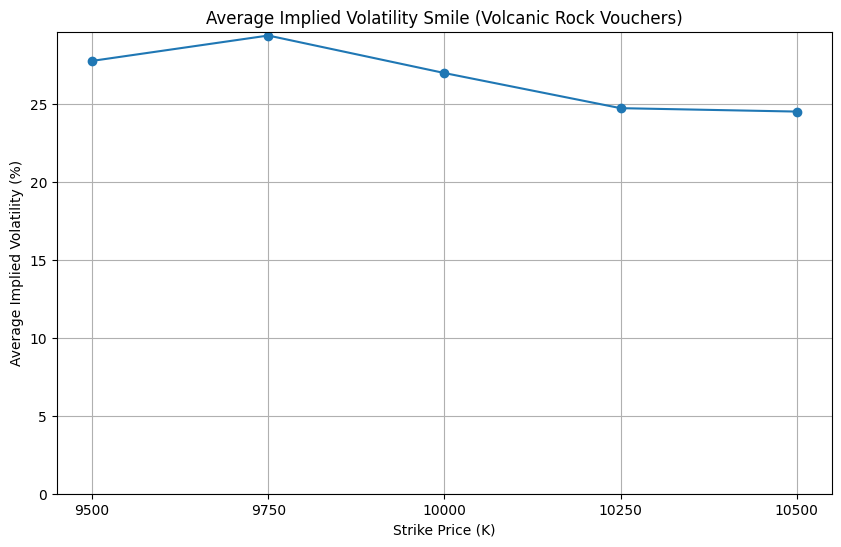

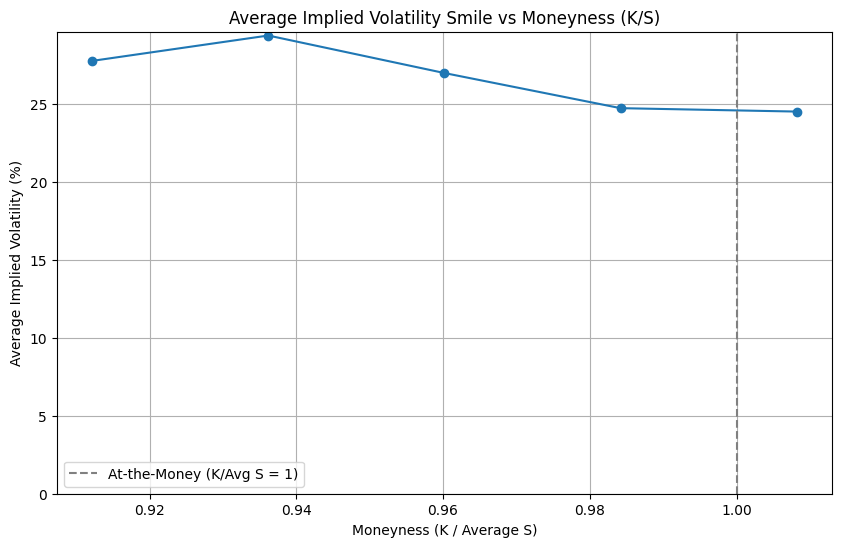

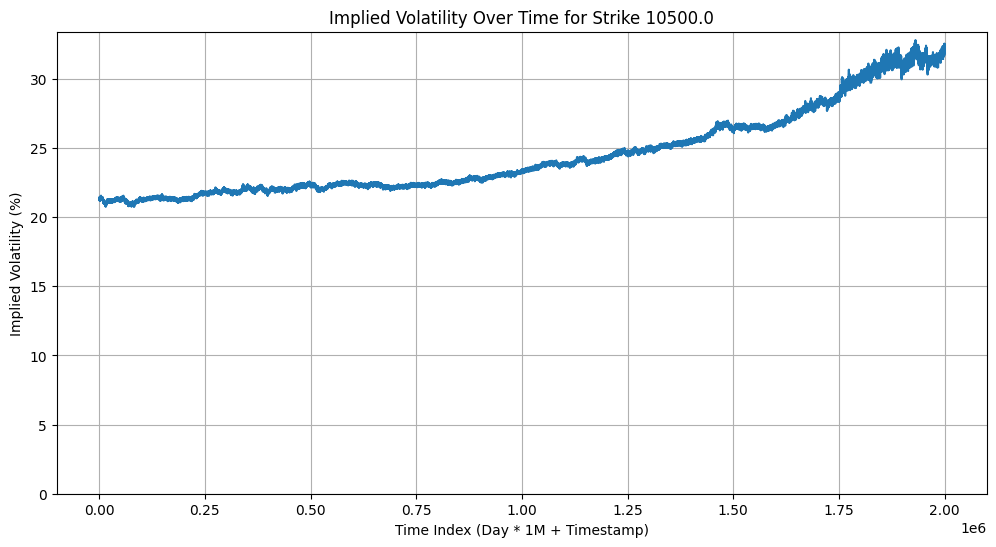


Summary Statistics for Calculated Metrics:
product  VOLCANIC_ROCK           tte  VOLCANIC_ROCK_VOUCHER_9500_iv  \
count     20000.000000  20000.000000                   18742.000000   
mean      10414.627205      0.007937                       0.277371   
std          88.144794      0.002291                       0.184387   
min       10152.500000      0.003969                       0.000000   
25%       10388.146795      0.005953                       0.000000   
50%       10436.173326      0.007937                       0.357618   
75%       10474.198855      0.009921                       0.419969   
max       10585.500000      0.011905                       0.523847   

product  VOLCANIC_ROCK_VOUCHER_9750_iv  VOLCANIC_ROCK_VOUCHER_10000_iv  \
count                     19337.000000                    19568.000000   
mean                          0.293626                        0.269585   
std                           0.085673                        0.026026   
min                 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes import black_scholes
from py_vollib.black_scholes.implied_volatility import implied_volatility
import warnings
import time

# Suppress specific warnings if needed (e.g., from py_vollib)
warnings.filterwarnings("ignore", category=RuntimeWarning) # py_vollib can throw RuntimeWarnings

# --- Configuration ---
DATA_FILES = {
    'prices': [
        'prices_round_3_day_0.csv',
        'prices_round_3_day_1.csv',
        'prices_round_3_day_2.csv',
    ],
    # Trades not strictly needed for IV calculation from prices
    # 'trades': [
    #     'trades_round_3_day_0.csv',
    #     'trades_round_3_day_1.csv',
    #     'trades_round_3_day_2.csv',
    # ]
}

PRODUCTS_TO_ANALYZE = [
    'VOLCANIC_ROCK',
    'VOLCANIC_ROCK_VOUCHER_9500',
    'VOLCANIC_ROCK_VOUCHER_9750',
    'VOLCANIC_ROCK_VOUCHER_10000',
    'VOLCANIC_ROCK_VOUCHER_10250',
    'VOLCANIC_ROCK_VOUCHER_10500',
]

VOLCANIC_ROCK_PRODUCT = 'VOLCANIC_ROCK'
VOUCHER_PREFIX = 'VOLCANIC_ROCK_VOUCHER_'

# Black-Scholes Parameters
RISK_FREE_RATE = 0.0  # Assume 0% risk-free rate
TRADING_DAYS_PER_YEAR = 252.0
STEPS_PER_DAY = 1_000_000
TOTAL_STEPS = 3 * STEPS_PER_DAY
EXPIRY_STEP = TOTAL_STEPS # Assume expiry right at the end of the last day

# --- Functions ---

def load_data(file_paths):
    """Loads and concatenates multiple CSV files."""
    all_dfs = []
    for file in file_paths:
        try:
            print(f"Loading {file}...")
            # Read only necessary columns to save memory
            df = pd.read_csv(
                file,
                delimiter=';',
                usecols=['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1']
            )
            # Clean column names if necessary (remove leading/trailing spaces)
            df.columns = df.columns.str.strip()
            all_dfs.append(df)
            print(f"Loaded {file} shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    if not all_dfs:
        raise ValueError("No data loaded.")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"\nCombined DataFrame shape: {combined_df.shape}")
    print(f"Columns: {combined_df.columns.tolist()}")
    return combined_df

def calculate_wmp(df):
    """Calculates the Weighted Mid-Price (WMP)."""
    # Ensure necessary columns are numeric and handle potential NaNs before calculation
    for col in ['bid_price_1', 'ask_price_1', 'bid_volume_1', 'ask_volume_1']:
         if col in df.columns:
              df[col] = pd.to_numeric(df[col], errors='coerce')

    # Replace NaNs in volume with 0 for calculation, price NaNs will propagate
    df['bid_volume_1'] = df['bid_volume_1'].fillna(0)
    df['ask_volume_1'] = df['ask_volume_1'].fillna(0)

    # Calculate WMP, handle division by zero
    denominator = df['bid_volume_1'] + df['ask_volume_1']
    numerator = df['bid_price_1'] * df['ask_volume_1'] + df['ask_price_1'] * df['bid_volume_1']

    # Where denominator is 0, result is NaN (or could use mid-price as fallback)
    df['wmp'] = np.where(denominator > 0, numerator / denominator, np.nan)

    # Fallback to mid-price if WMP is NaN but prices are available
    mid_price = (df['bid_price_1'] + df['ask_price_1']) / 2
    df['wmp'] = df['wmp'].fillna(mid_price)

    return df

def calculate_tte(day, timestamp):
    """Calculates Time To Expiry in years."""
    current_step = day * STEPS_PER_DAY + timestamp
    steps_remaining = max(0, EXPIRY_STEP - current_step) # Ensure non-negative
    # TTE in years = (Steps Left / Steps Per Day) / Trading Days Per Year
    tte_years = (steps_remaining / STEPS_PER_DAY) / TRADING_DAYS_PER_YEAR
    # Add a small epsilon to avoid T=0 exactly at expiry if needed by IV calc
    return tte_years + 1e-9

def calculate_iv(option_price, S, K, T, r, flag='c'):
    """Safely calculates Implied Volatility."""
    # Basic checks for valid inputs for py_vollib
    if pd.isna(option_price) or pd.isna(S) or pd.isna(K) or pd.isna(T) or \
       option_price <= 0 or S <= 0 or K <= 0 or T <= 0:
        return np.nan
    # Check basic call option arbitrage bounds (Price >= Intrinsic Value)
    intrinsic_value = max(0, S - K) if flag == 'c' else max(0, K - S)
    # Allow for tiny numerical inaccuracies or zero spread
    if option_price < intrinsic_value - 0.01:
        return np.nan # Price below intrinsic value, IV calculation likely fails

    try:
        # Use py_vollib's implied_volatility function
        iv = implied_volatility(price=option_price, S=S, K=K, t=T, r=r, flag=flag)
        # Check for unrealistic IV values (e.g., > 500% might indicate an issue)
        if iv > 5.0: # 500% vol
             return np.nan
        return iv
    except Exception:
        # Catch any error during IV calculation (e.g., ValueError, ZeroDivisionError)
        return np.nan

# --- Main Execution ---
start_time = time.time()

# 1. Load Data
prices_df = load_data(DATA_FILES['prices'])

# 2. Filter Data
filtered_prices = prices_df[prices_df['product'].isin(PRODUCTS_TO_ANALYZE)].copy()
print(f"\nFiltered Volcanic Prices shape: {filtered_prices.shape}")

# 3. Calculate WMP
print("\nCalculating Weighted Mid Prices (WMP)...")
filtered_prices = calculate_wmp(filtered_prices)

# Drop rows where WMP calculation resulted in NaN (due to missing bids/asks)
# Only keep timestamp/product combinations where WMP is valid
initial_rows = len(filtered_prices)
filtered_prices.dropna(subset=['wmp'], inplace=True)
print(f"Dropped {initial_rows - len(filtered_prices)} rows due to NaN WMP.")


# 4. Pivot Data
print("\nPivoting data...")
try:
    pivot_df = filtered_prices.pivot_table(
        index=['day', 'timestamp'],
        columns='product',
        values='wmp' # Use WMP for calculations
    )
    # Optional: Also pivot other useful columns like best bid/ask if needed later
    # pivot_spread = filtered_prices.pivot_table(...)
except Exception as e:
     print(f"Error during pivoting: {e}")
     # Diagnostic: Check for duplicate index entries
     duplicates = filtered_prices[filtered_prices.duplicated(subset=['day', 'timestamp', 'product'], keep=False)]
     if not duplicates.empty:
         print("Found duplicate entries for product/day/timestamp combinations:")
         print(duplicates.head())
     raise # Re-raise the exception after diagnostics

print(f"Pivoted DataFrame shape: {pivot_df.shape}")
print(f"Pivoted columns: {pivot_df.columns.tolist()}")

# Ensure the underlying asset column exists
if VOLCANIC_ROCK_PRODUCT not in pivot_df.columns:
    raise ValueError(f"Underlying asset '{VOLCANIC_ROCK_PRODUCT}' not found in pivoted data.")

# Drop rows where the underlying price is missing after pivot
initial_pivot_rows = len(pivot_df)
pivot_df.dropna(subset=[VOLCANIC_ROCK_PRODUCT], inplace=True)
print(f"Dropped {initial_pivot_rows - len(pivot_df)} rows due to missing underlying WMP after pivot.")

# Reset index to access day/timestamp easily
pivot_df.reset_index(inplace=True)

# 5. Calculate TTE
print("\nCalculating Time-To-Expiry (TTE)...")
pivot_df['tte'] = pivot_df.apply(lambda row: calculate_tte(row['day'], row['timestamp']), axis=1)

# 6. Calculate Implied Volatility (IV)
print("\nCalculating Implied Volatility (IV), BS Price, and Mispricing...")
vouchers = [p for p in PRODUCTS_TO_ANALYZE if p.startswith(VOUCHER_PREFIX)]
underlying_col = VOLCANIC_ROCK_PRODUCT
iv_results = {}
iv_failures = {}

for voucher in vouchers:
    if voucher not in pivot_df.columns:
        print(f"Warning: Voucher {voucher} column not found in pivoted data. Skipping.")
        continue

    start_iv_time = time.time()
    print(f" Processing {voucher}...")
    try:
        strike_price = float(voucher.split('_')[-1]) # Extract strike price
    except ValueError:
        print(f" Could not extract strike price from {voucher}. Skipping.")
        continue

    iv_col_name = f'{voucher}_iv'
    bs_price_col = f'{voucher}_bs_price' # For potential later use
    mispricing_col = f'{voucher}_mispricing' # For potential later use

    # Apply the IV calculation row by row
    pivot_df[iv_col_name] = pivot_df.apply(
        lambda row: calculate_iv(
            option_price=row[voucher],
            S=row[underlying_col],
            K=strike_price,
            T=row['tte'],
            r=RISK_FREE_RATE,
            flag='c'
        ),
        axis=1
    )

    # Calculate failure rate
    total_rows = len(pivot_df)
    failed_count = pivot_df[iv_col_name].isna().sum()
    iv_failures[voucher] = failed_count
    if total_rows > 0:
         failure_rate = (failed_count / total_rows) * 100
         print(f"  {voucher}: IV calculation failures: {failed_count} ({failure_rate:.2f}%)")
    else:
         print(f"  {voucher}: No rows to process.")


    # Optional: Calculate BS price using average IV later if needed
    # Optional: Calculate mispricing = Market Price - BS Price

    iv_results[voucher] = {'strike': strike_price, 'iv_col': iv_col_name}
    print(f"  Finished {voucher} IV in {time.time() - start_iv_time:.2f} seconds.")


print("\nIV Calculation Failure Report:")
for voucher, count in iv_failures.items():
    total_rows = len(pivot_df)
    if total_rows > 0:
        rate = (count / total_rows) * 100
        print(f"  {voucher}: {count} failures ({rate:.2f}%)")
    else:
        print(f"  {voucher}: {count} failures (N/A%)")


# --- 7. Analyze & Visualize ---

# Calculate Average IV per Strike
average_iv_data = []
strikes = []
avg_ivs = []

print("\nCalculating Average IV per Strike...")
for voucher, data in iv_results.items():
    strike = data['strike']
    iv_col = data['iv_col']
    valid_ivs = pivot_df[iv_col].dropna()
    if not valid_ivs.empty:
        average_iv = valid_ivs.mean()
        print(f"  Strike {strike}: Average IV = {average_iv:.4f} (from {len(valid_ivs)} data points)")
        strikes.append(strike)
        avg_ivs.append(average_iv)
        average_iv_data.append({'strike': strike, 'average_iv': average_iv})
    else:
        print(f"  Strike {strike}: No valid IV data found.")
        strikes.append(strike)
        avg_ivs.append(np.nan) # Append NaN if no data
        average_iv_data.append({'strike': strike, 'average_iv': np.nan})

# Create a DataFrame for easier handling
avg_iv_df = pd.DataFrame(average_iv_data).sort_values('strike')

# --- Visualization ---
print("\nGenerating Plots...")

# Plot 1: Volatility Smile (IV vs Strike)
plt.figure(figsize=(10, 6))
plt.plot(avg_iv_df['strike'], avg_iv_df['average_iv'] * 100, marker='o', linestyle='-') # Plot IV as percentage
plt.title('Average Implied Volatility Smile (Volcanic Rock Vouchers)')
plt.xlabel('Strike Price (K)')
plt.ylabel('Average Implied Volatility (%)')
plt.grid(True)
plt.xticks(avg_iv_df['strike'].unique()) # Ensure all strikes are marked
plt.ylim(bottom=0) # IV cannot be negative
plt.show()


# Plot 2: Volatility Smile (IV vs Moneyness K/S) - Averaged
# Calculate average S and average K/S for plotting
average_S = pivot_df[underlying_col].mean()
avg_iv_df['moneyness'] = avg_iv_df['strike'] / average_S

plt.figure(figsize=(10, 6))
plt.plot(avg_iv_df['moneyness'], avg_iv_df['average_iv'] * 100, marker='o', linestyle='-') # Plot IV as percentage
plt.title('Average Implied Volatility Smile vs Moneyness (K/S)')
plt.xlabel('Moneyness (K / Average S)')
plt.ylabel('Average Implied Volatility (%)')
plt.grid(True)
plt.axvline(1.0, color='grey', linestyle='--', label='At-the-Money (K/Avg S = 1)')
plt.legend()
plt.ylim(bottom=0)
plt.show()


# Plot 3: IV over time for a specific strike (e.g., ATM or near ATM)
# Find near ATM strike based on average S
atm_strike_approx = min(strikes, key=lambda k: abs(k - average_S))
atm_voucher = f"{VOUCHER_PREFIX}{int(atm_strike_approx)}"
if atm_voucher in iv_results:
    atm_iv_col = iv_results[atm_voucher]['iv_col']
    plt.figure(figsize=(12, 6))
    # Create a combined time index for plotting
    pivot_df['time_idx'] = pivot_df['day'] * STEPS_PER_DAY + pivot_df['timestamp']
    plt.plot(pivot_df['time_idx'], pivot_df[atm_iv_col] * 100) # Plot IV as percentage
    plt.title(f'Implied Volatility Over Time for Strike {atm_strike_approx}')
    plt.xlabel('Time Index (Day * 1M + Timestamp)')
    plt.ylabel('Implied Volatility (%)')
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.show()
else:
    print(f"Could not find data for approximate ATM voucher: {atm_voucher}")


# --- Summary ---
print("\nSummary Statistics for Calculated Metrics:")
print(pivot_df[[underlying_col, 'tte'] + [v['iv_col'] for v in iv_results.values()]].describe())

print(f"\nTotal execution time: {time.time() - start_time:.2f} seconds")

In [ ]:
!pip install py_vollib
!pip install py_vollib_vectorized
!pip install scipy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62833 sha256=91a84b339dbfb6fb2425f6a1bbd8f4f097a71093d19555dc8cf5ac6327bfc00f
  Stored in directory: /root/.cache/pip/wheels/c0/5c/8f/1ed590a10a2cca3cbfa7a7caa29fb5d729b3e1f819bfda4b5e
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24451 sha256=ffa735064d4dbdbed1cf817ddf72d81ae68290e26b5e2dbff734282e14acaecd
  Stored in directory: /root/.cache/pip/wheels/d9/20/b1/018f644bacb669d5cd6af600fe09ee0729ae5d75875a9f3043
Successfully built py_vollib py_lets_be_rational
